# Лабораторная работа 1: Классификация изображений

## Import libs

In [1]:
import einops
from tqdm.notebook import tqdm

from torchsummary import summary

import time

import pandas as pd
import torch
from torch import nn
import torchvision
import torch.optim as optim
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomCrop


## Get data

In [2]:
import os


In [3]:
cars_annos_train_df = pd.read_csv('cars_annos_train.csv')
cars_annos_test_df = pd.read_csv('cars_annos_test.csv')

cars_annos_train_df


,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname
0,39,116,569,375,14,00001.jpg
1,36,116,868,587,3,00002.jpg
2,85,109,601,381,91,00003.jpg
3,621,393,1484,1096,134,00004.jpg
4,14,36,133,99,106,00005.jpg
...,...,...,...,...,...,...
8139,3,44,423,336,78,08140.jpg
8140,138,150,706,523,196,08141.jpg
8141,26,246,660,449,163,08142.jpg
8142,78,526,1489,908,112,08143.jpg


In [4]:
class_counts = cars_annos_train_df['class'].value_counts()
class_counts


class
119    68
79     49
161    48
167    48
144    47
       ..
175    31
64     30
158    29
99     28
136    24
Name: count, Length: 196, dtype: int64

In [5]:
num_classes = 50

In [6]:
top_classes = cars_annos_train_df['class'].value_counts().head(num_classes).index
filtered_train_df = cars_annos_train_df[cars_annos_train_df['class'].isin(top_classes)]
filtered_test_df = cars_annos_test_df[cars_annos_test_df['class'].isin(top_classes)]

class_mapping = {old_class: new_class for new_class, old_class in enumerate(top_classes)}

filtered_train_df.loc[:, 'class'] = filtered_train_df['class'].replace(class_mapping)
filtered_test_df.loc[:, 'class'] = filtered_test_df['class'].replace(class_mapping)

filtered_train_df


,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname
5,259,289,515,416,35,00006.jpg
6,88,80,541,397,45,00007.jpg
8,20,126,1269,771,3,00009.jpg
9,21,110,623,367,47,00010.jpg
17,3,8,190,147,38,00018.jpg
...,...,...,...,...,...,...
8127,61,138,768,526,6,08128.jpg
8130,19,77,619,398,0,08131.jpg
8131,53,65,424,269,25,08132.jpg
8138,117,84,583,403,48,08139.jpg


In [7]:
filtered_class_counts = filtered_train_df['class'].value_counts()
filtered_class_counts


class
0     68
1     49
3     48
2     48
5     47
4     47
7     46
13    46
12    46
10    46
11    46
6     46
14    46
15    46
8     46
9     46
22    45
34    45
36    45
37    45
16    45
38    45
25    45
39    45
27    45
20    45
32    45
33    45
17    45
23    45
35    45
31    45
19    45
24    45
26    45
18    45
28    45
21    45
30    45
29    45
46    44
45    44
40    44
43    44
41    44
44    44
48    44
49    44
47    44
42    44
Name: count, dtype: int64

In [8]:
filtered_train_df_len = len(filtered_train_df)

In [9]:
filtered_test_df_len = len(filtered_test_df)

In [10]:
cars_annos_train_df = filtered_train_df.sample(filtered_train_df_len, random_state=42).reset_index(drop=True)
cars_annos_test_df = filtered_test_df.sample(filtered_test_df_len, random_state=42).reset_index(drop=True)


In [11]:
cars_annos_train_df['class'] = cars_annos_train_df['class'].astype('category')
cars_annos_test_df['class'] = cars_annos_test_df['class'].astype('category')


## Train test split

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from torchvision.transforms.functional import crop
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


In [13]:
def plot_batch(images: torch.Tensor, labels: torch.Tensor):
    num_images = images.size(0)
    num_rows = int(np.ceil(np.sqrt(num_images)))

    fig, axs = plt.subplots(num_rows, num_rows)
    fig.subplots_adjust(hspace=0.1, wspace=1)

    for i, ax in enumerate(axs.flatten()):
        if i < num_images:
            image, label = images[i], str(int(labels[i]))
            image = image.numpy().transpose((1, 2, 0))
            image = (image * 0.5) + 0.5

            ax.imshow(image.squeeze())
            ax.set_title(int(label), fontsize=12)
            ax.axis("off")
        else:
            ax.axis("off")

    plt.show()
    

In [14]:
def padding(img, expected_size):
    desired_size = expected_size
    delta_width = desired_size[0] - img.size[0]
    delta_height = desired_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)


def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)
    

In [57]:
class ImageDataset(Dataset):
    def __init__(self, image_dataframe, image_dir, transform=None):
        self.image_dataframe = image_dataframe
        self.transform = transform
        self.image_dataframe['im_path'] = self.image_dataframe['fname'].apply(lambda x: os.path.join(image_dir, x))

    def __len__(self):
        return len(self.image_dataframe)

    def __getitem__(self, idx):
        image_path = self.image_dataframe.loc[idx, 'im_path']
        label = self.image_dataframe.loc[idx, 'class']
            
        image = Image.open(image_path)

        if image.mode == 'L':
            image = image.convert('RGB')

        bbox_x1 = self.image_dataframe.loc[idx, 'bbox_x1']
        bbox_y1 = self.image_dataframe.loc[idx, 'bbox_y1']
        bbox_x2 = self.image_dataframe.loc[idx, 'bbox_x2']
        bbox_y2 = self.image_dataframe.loc[idx, 'bbox_y2']

        width = bbox_x2 - bbox_x1
        height = bbox_y2 - bbox_y1

        size = max(width, height)

        crop_x1 = bbox_x1
        crop_y1 = bbox_y1

        pad_y = max(0, (size - height) // 2)

        old_image = crop(image, top=bbox_y1, left=bbox_x1, height=bbox_y2-bbox_y1, width=bbox_x2-bbox_x1)

        image = resize_with_padding(old_image, (size, size))

        if self.transform:
            image = self.transform(image)

        return image, label
        

In [16]:
torch.manual_seed(42)

# transform = transforms.Compose([
#   transforms.Resize((224, 224)),
#   transforms.ToTensor(),
#   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
# ])

transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = ImageDataset(cars_annos_train_df, 'cars_train', transform=transform)
test_set = ImageDataset(cars_annos_test_df, 'cars_test', transform=transform)


In [17]:
batch_size = 4

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


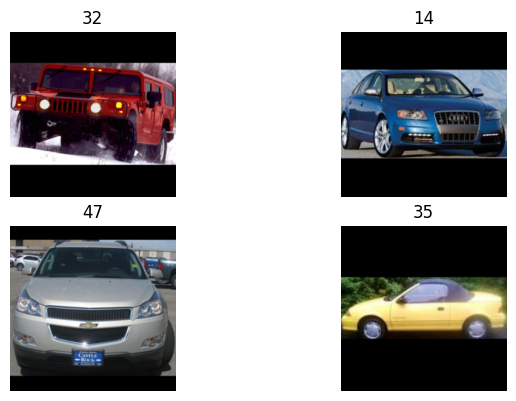

In [18]:
batch_images, batch_labels = next(iter(train_loader))
plot_batch(batch_images, batch_labels)


## ViT


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [20]:
patch_size = 16         # Patch size (P) = 16
latent_size = 768       # Latent vector (D). ViT-Base uses 768
n_channels = 3          # Number of channels for input images
num_heads = 12          # ViT-Base uses 12 heads
num_encoders = 12       # ViT-Base uses 12 encoder layers
dropout = 0.1           # Dropout = 0.1 is used with ViT-Base & ImageNet-21k
# num_classes = 197       # Number of classes in the dataset
size = 224              # Size used for training = 224

epochs = 30             # Number of epochs
base_lr = 10e-3         # Base LR
weight_decay = 0.03     # Weight decay for ViT-Base (on ImageNet-21k)


In [21]:
epochs = 10

In [58]:
class InputEmbedding(nn.Module):
    def __init__(self, patch_size=patch_size, n_channels=n_channels, device=device, latent_size=latent_size, batch_size=batch_size):
        super(InputEmbedding, self).__init__()
        self.latent_size = latent_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.device = device
        self.batch_size = batch_size
        self.input_size = self.patch_size * self.patch_size * self.n_channels

        self.linearProjection = nn.Linear(self.input_size, self.latent_size)

        self.class_token = nn.Parameter(torch.randn(self.batch_size, 1, self.latent_size)).to(self.device)

        self.pos_embedding = nn.Parameter(torch.randn(self.batch_size, 1, self.latent_size)).to(self.device)


    def forward(self, input_data):

        input_data = input_data.to(self.device)

        patches = einops.rearrange(
            input_data, 'b c (h h1) (w w1) -> b (h w) (h1 w1 c)', h1=self.patch_size, w1=self.patch_size)

        linear_projection = self.linearProjection(patches).to(self.device)
        b, n, _ = linear_projection.shape

        linear_projection = torch.cat((self.class_token, linear_projection), dim=1)
        pos_embed = einops.repeat(self.pos_embedding, 'b 1 d -> b m d', m=n+1)

        linear_projection += pos_embed

        return linear_projection
        

In [59]:
class EncoderBlock(nn.Module):
    def __init__(self, latent_size=latent_size, num_heads=num_heads, device=device, dropout=dropout):
        super(EncoderBlock, self).__init__()

        self.latent_size = latent_size
        self.num_heads = num_heads
        self.device = device
        self.dropout = dropout

        self.norm = nn.LayerNorm(self.latent_size)
        
        self.multihead = nn.MultiheadAttention(
            self.latent_size, self.num_heads, dropout=self.dropout)          

        self.enc_MLP = nn.Sequential(
            nn.Linear(self.latent_size, self.latent_size*4),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.latent_size*4, self.latent_size),
            nn.Dropout(self.dropout)
        )

    def forward(self, embedded_patches):
        firstNorm_out = self.norm(embedded_patches)
        attention_output = self.multihead(firstNorm_out, firstNorm_out, firstNorm_out)[0]

        first_added_output = attention_output + embedded_patches

        secondNorm_out = self.norm(first_added_output)
        ff_output = self.enc_MLP(secondNorm_out)

        return ff_output + first_added_output
        

In [60]:
class VitTransformer(nn.Module):
    def __init__(self, num_encoders=num_encoders, latent_size=latent_size, device=device, num_classes=num_classes, dropout=dropout):
        super(VitTransformer, self).__init__()
        self.num_encoders = num_encoders
        self.latent_size = latent_size
        self.device = device
        self.num_classes = num_classes
        self.dropout = dropout

        self.embedding = InputEmbedding()

        self.encStack = nn.ModuleList([EncoderBlock() for i in range(self.num_encoders)])

        self.MLP_head = nn.Sequential(
            nn.LayerNorm(self.latent_size),
            nn.Linear(self.latent_size, self.latent_size),
            nn.Linear(self.latent_size, self.num_classes)
        )

    def forward(self, test_input):
        enc_output = self.embedding(test_input)

        for enc_layer in self.encStack:
            enc_output = enc_layer.forward(enc_output)

        cls_token_embedding = enc_output[:, 0]

        return self.MLP_head(cls_token_embedding)
        

In [61]:
model = VitTransformer(num_encoders, latent_size, device, num_classes).to(device)


In [62]:
import torch
import torch.nn as nn
import torch.optim as optim

class AdaBound(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3, weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, weight_decay=weight_decay)
        super(AdaBound, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                lower_bound = group['lr'] * (1.0 - 1.0 / (group['gamma'] * state['step'] + 1))
                upper_bound = group['lr'] * (1.0 + 1.0 / (group['gamma'] * state['step']))

                lr = min(max(lower_bound, group['lr']), upper_bound)

                p.data.addcdiv_(-lr, exp_avg, torch.sqrt(exp_avg_sq) + group['weight_decay'] * p.data)

        return loss
        

## Training

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score

def fine_tune(name, model, train_data_loader, valid_data_loader, writer, start_epoch=0, epochs=10, device='cuda', optimizer='adabound', learning_rate=0.001):
    min_loss = np.inf
    
    if optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == 'adabound':
        optimizer = AdaBound(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")

    model.to(device)
    model.train()
    
    for ep in range(epochs):
        running_loss = 0.0
        train_predictions = []
        train_labels = []

        epoch = ep + start_epoch

        for inputs, labels in tqdm(train_data_loader, desc=f"Epoch {epoch+1}/{start_epoch + epochs}"):
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # print('outputs', outputs)
            # print('labels', labels)
            
            loss = nn.CrossEntropyLoss()(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            train_predictions.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        loss = running_loss / len(train_data_loader.dataset)
        
        valid_loss, f1, accuracy = calculate_metrics(model, valid_data_loader, device)

        if valid_loss < min_loss:
            print('Saving model...')
            min_loss = valid_loss

            torch.save(model.state_dict(), f'./checkpoints/{name}_{epoch}_{int(valid_loss)}.pt')

        writer.add_scalar("Training Loss", loss, epoch)
        writer.add_scalar("Validation Loss", valid_loss, epoch)
        writer.add_scalar("Validation F1 Score", f1, epoch)
        writer.add_scalar("Validation Accuracy", accuracy, epoch)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss}, Validation loss: {valid_loss}, Min loss: {min_loss}, F1 Score: {f1}, Accuracy: {accuracy}')
    
    return model

def calculate_metrics(model, data_loader, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    predictions = []
    labels = []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, batch_labels in tqdm(data_loader):
            inputs, batch_labels = inputs.to(device), batch_labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, batch_labels)
            
            total_loss += loss.item()
            predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    model.train()
    
    predictions = torch.tensor(predictions)
    labels = torch.tensor(labels)

    f1 = f1_score(predictions, labels, average='macro')
    accuracy = torch.sum(predictions == labels).item() / len(labels)

    return total_loss, f1, accuracy


In [34]:
from torch.utils.tensorboard import SummaryWriter

def fine_tune_model_with_writer(name, model, start_epoch=0, epochs=10, device='cuda', optimizer='adabound', writer=None, learning_rate=0.001):
    # writer = SummaryWriter(name)
    model = model.to(device)
    model = fine_tune(name, model, train_loader, test_loader, writer, start_epoch, epochs, device, optimizer, learning_rate)
    writer.flush()

    return model
    

In [38]:
import optuna
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from vit_pytorch import ViT
from adabound import AdaBound
from tqdm import tqdm
from sklearn.metrics import f1_score

# patch_size = 16         # Patch size (P) = 16
# latent_size = 768       # Latent vector (D). ViT-Base uses 768
# n_channels = 3          # Number of channels for input images
# num_heads = 12          # ViT-Base uses 12 heads
# num_encoders = 12       # ViT-Base uses 12 encoder layers
# dropout = 0.1           # Dropout = 0.1 is used with ViT-Base & ImageNet-21k
# # num_classes = 197       # Number of classes in the dataset
# size = 224              # Size used for training = 224

# epochs = 30             # Number of epochs
# base_lr = 10e-3         # Base LR
# weight_decay = 0.03     # Weight decay for ViT-Base (on ImageNet-21k)

def objective(trial):
    size = trial.suggest_int('image_size', 224, 224)
    patch_size = trial.suggest_int('patch_size', 16, 16)
    latent_size = trial.suggest_int('dim', 256, 1024)
    num_encoders = trial.suggest_int('depth', 6, 10)
    num_heads = trial.suggest_int('heads', 12, 16)
    dropout = trial.suggest_float('dropout', 0.1, 0.3)

    model_vit_adabound = ViT(
        image_size=size,
        patch_size=patch_size,
        num_classes=num_classes,
        dim=latent_size,
        depth=num_encoders,
        heads=num_heads,
        mlp_dim=2048,
        dropout=dropout,
        emb_dropout=dropout
    ).to(device)

    trial_name = f"vit_adabound_trial_{trial.number}"

    writer = SummaryWriter(trial_name)

    fine_tune_model_with_writer(trial_name, model_vit_adabound, epochs=15, optimizer='adabound', writer=writer)

    validation_loss, _, validation_accuracy = calculate_metrics(model_vit_adabound, test_loader, device)
    writer.close()

    return validation_accuracy

n_trials = 20

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials)

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2024-01-20 18:16:51,147] A new study created in memory with name: no-name-4ea8e6ae-563a-44a2-b5ab-e360074140d1
100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.53it/s]


Saving model...
Epoch 1/15, Loss: 4.557139188377003, Validation loss: 2434.9352855682373, Min loss: 2434.9352855682373, F1 Score: 0.0007635574837310196, Accuracy: 0.019460415745245468


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.48it/s]


Saving model...
Epoch 2/15, Loss: 4.170322285294794, Validation loss: 2251.1322853565216, Min loss: 2251.1322853565216, F1 Score: 0.001167883211678832, Accuracy: 0.03007518796992481


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.67it/s]


Saving model...
Epoch 3/15, Loss: 3.945598952677451, Validation loss: 2215.20597243309, Min loss: 2215.20597243309, F1 Score: 0.0027843812679137973, Accuracy: 0.0291906236178682


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 21.86it/s]


Saving model...
Epoch 4/15, Loss: 3.9284247529522323, Validation loss: 2212.9270825386047, Min loss: 2212.9270825386047, F1 Score: 0.0024261011560381095, Accuracy: 0.03140203449800973


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 22.91it/s]


Saving model...
Epoch 5/15, Loss: 3.9114928117317564, Validation loss: 2206.2329449653625, Min loss: 2206.2329449653625, F1 Score: 0.001970923119647535, Accuracy: 0.025210084033613446


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.05it/s]


Saving model...
Epoch 6/15, Loss: 3.8970031299390904, Validation loss: 2204.861274242401, Min loss: 2204.861274242401, F1 Score: 0.0060945800380408695, Accuracy: 0.03847854931446263


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.57it/s]


Saving model...
Epoch 7/15, Loss: 3.872397663919593, Validation loss: 2174.681992292404, Min loss: 2174.681992292404, F1 Score: 0.014020921400916868, Accuracy: 0.03803626713843432


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 22.69it/s]


Epoch 8/15, Loss: 3.82190463289612, Validation loss: 2243.8815412521362, Min loss: 2174.681992292404, F1 Score: 0.009661353917481233, Accuracy: 0.038920831490490936


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 22.88it/s]


Saving model...
Epoch 9/15, Loss: 3.797532263206612, Validation loss: 2142.279721736908, Min loss: 2142.279721736908, F1 Score: 0.013097712317082993, Accuracy: 0.045112781954887216


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 22.95it/s]


Epoch 10/15, Loss: 3.7728180062786483, Validation loss: 2152.1902346611023, Min loss: 2142.279721736908, F1 Score: 0.01761891869460032, Accuracy: 0.043343653250773995


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.46it/s]


Epoch 11/15, Loss: 3.7623946286206897, Validation loss: 2198.31524848938, Min loss: 2142.279721736908, F1 Score: 0.01768507791242149, Accuracy: 0.044228217602830605


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.34it/s]


Saving model...
Epoch 12/15, Loss: 3.7313174833415323, Validation loss: 2139.564527273178, Min loss: 2139.564527273178, F1 Score: 0.026490142942121125, Accuracy: 0.047766475011057054


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.44it/s]


Epoch 13/15, Loss: 3.721374189379333, Validation loss: 2152.9552001953125, Min loss: 2139.564527273178, F1 Score: 0.027046596709212157, Accuracy: 0.054400707651481646


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.41it/s]


Epoch 14/15, Loss: 3.6994689934942784, Validation loss: 2169.904733777046, Min loss: 2139.564527273178, F1 Score: 0.020095939848997206, Accuracy: 0.04555506413091552


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.53it/s]


Epoch 15/15, Loss: 3.674966070398682, Validation loss: 2143.684463262558, Min loss: 2139.564527273178, F1 Score: 0.029373639278437544, Accuracy: 0.05572755417956656


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.53it/s]
[I 2024-01-20 18:39:02,512] Trial 0 finished with value: 0.05572755417956656 and parameters: {'image_size': 224, 'patch_size': 16, 'dim': 571, 'depth': 9, 'heads': 12, 'dropout': 0.19269592850426362}. Best is trial 0 with value: 0.05572755417956656.
100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.66it/s]


Saving model...
Epoch 1/15, Loss: 4.518435628955209, Validation loss: 2552.7673404216766, Min loss: 2552.7673404216766, F1 Score: 0.0007819287576020851, Accuracy: 0.019902697921273773


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.70it/s]


Saving model...
Epoch 2/15, Loss: 4.121408951558762, Validation loss: 2223.745001554489, Min loss: 2223.745001554489, F1 Score: 0.0007655502392344498, Accuracy: 0.019460415745245468


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.01it/s]


Saving model...
Epoch 3/15, Loss: 3.92062447057523, Validation loss: 2205.3645265102386, Min loss: 2205.3645265102386, F1 Score: 0.0030519580664393397, Accuracy: 0.02697921273772667


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.49it/s]


Saving model...
Epoch 4/15, Loss: 3.8775377003553397, Validation loss: 2195.4330060482025, Min loss: 2195.4330060482025, F1 Score: 0.0041766042948123425, Accuracy: 0.030959752321981424


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 27.32it/s]


Saving model...
Epoch 5/15, Loss: 3.8137258584706815, Validation loss: 2185.5638115406036, Min loss: 2185.5638115406036, F1 Score: 0.011440193207942557, Accuracy: 0.047766475011057054


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.54it/s]


Saving model...
Epoch 6/15, Loss: 3.7696092509264294, Validation loss: 2138.14231467247, Min loss: 2138.14231467247, F1 Score: 0.015916670521018368, Accuracy: 0.04201680672268908


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 26.95it/s]


Epoch 7/15, Loss: 3.726816883971194, Validation loss: 2237.292379140854, Min loss: 2138.14231467247, F1 Score: 0.0117894403181777, Accuracy: 0.044228217602830605


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.51it/s]


Epoch 8/15, Loss: 3.688332086470537, Validation loss: 2155.1438813209534, Min loss: 2138.14231467247, F1 Score: 0.028498717777703856, Accuracy: 0.0508624502432552


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.23it/s]


Epoch 9/15, Loss: 3.655519041996311, Validation loss: 2214.8772757053375, Min loss: 2138.14231467247, F1 Score: 0.023735850551706773, Accuracy: 0.044228217602830605


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 25.90it/s]


Epoch 10/15, Loss: 3.6172015157181674, Validation loss: 2145.91690993309, Min loss: 2138.14231467247, F1 Score: 0.01849747605031123, Accuracy: 0.05263157894736842


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 27.02it/s]


Saving model...
Epoch 11/15, Loss: 3.5891681812087888, Validation loss: 2114.361383676529, Min loss: 2114.361383676529, F1 Score: 0.03574952925367881, Accuracy: 0.06678460858027421


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.53it/s]


Epoch 12/15, Loss: 3.533445688538745, Validation loss: 2199.1735162734985, Min loss: 2114.361383676529, F1 Score: 0.034161544773149005, Accuracy: 0.06324635117204777


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.11it/s]


Epoch 13/15, Loss: 3.511680238466884, Validation loss: 2130.081258535385, Min loss: 2114.361383676529, F1 Score: 0.04390716912515672, Accuracy: 0.06324635117204777


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.17it/s]


Epoch 14/15, Loss: 3.493067153739679, Validation loss: 2149.9407165050507, Min loss: 2114.361383676529, F1 Score: 0.03314245222925967, Accuracy: 0.05661211853162318


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 25.97it/s]


Epoch 15/15, Loss: 3.483213663622444, Validation loss: 2193.4446195364, Min loss: 2114.361383676529, F1 Score: 0.036903612250843584, Accuracy: 0.06103494029190624


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.18it/s]
[I 2024-01-20 18:57:21,101] Trial 1 finished with value: 0.06103494029190624 and parameters: {'image_size': 224, 'patch_size': 16, 'dim': 536, 'depth': 7, 'heads': 12, 'dropout': 0.1202886836187001}. Best is trial 1 with value: 0.06103494029190624.
100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 22.99it/s]


Saving model...
Epoch 1/15, Loss: 5.024124216710213, Validation loss: 2596.3933091163635, Min loss: 2596.3933091163635, F1 Score: 0.0007465277777777776, Accuracy: 0.01901813356921716


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.10it/s]


Saving model...
Epoch 2/15, Loss: 4.1858323978762675, Validation loss: 2232.095716714859, Min loss: 2232.095716714859, F1 Score: 0.001095961940125319, Accuracy: 0.019460415745245468


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.10it/s]


Saving model...
Epoch 3/15, Loss: 3.9184730855669057, Validation loss: 2198.5196425914764, Min loss: 2198.5196425914764, F1 Score: 0.007234212112424221, Accuracy: 0.03361344537815126


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.52it/s]


Saving model...
Epoch 4/15, Loss: 3.866291684879191, Validation loss: 2179.806322813034, Min loss: 2179.806322813034, F1 Score: 0.012959869680939193, Accuracy: 0.04201680672268908


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 22.65it/s]


Saving model...
Epoch 5/15, Loss: 3.8317304763618805, Validation loss: 2166.23193025589, Min loss: 2166.23193025589, F1 Score: 0.018645140236649996, Accuracy: 0.04643962848297214


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.14it/s]


Epoch 6/15, Loss: 3.834599299049294, Validation loss: 2166.429148197174, Min loss: 2166.23193025589, F1 Score: 0.009450481166865182, Accuracy: 0.03449800973020787


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.17it/s]


Epoch 7/15, Loss: 3.8326056693702166, Validation loss: 2183.2699711322784, Min loss: 2166.23193025589, F1 Score: 0.008107021054332432, Accuracy: 0.03847854931446263


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.09it/s]


Saving model...
Epoch 8/15, Loss: 3.8056145128225936, Validation loss: 2157.8864765167236, Min loss: 2157.8864765167236, F1 Score: 0.02000449381696348, Accuracy: 0.0437859354268023


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.07it/s]


Epoch 9/15, Loss: 3.775758286569126, Validation loss: 2186.423327922821, Min loss: 2157.8864765167236, F1 Score: 0.020472910236637734, Accuracy: 0.04820875718708536


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.07it/s]


Saving model...
Epoch 10/15, Loss: 3.780905280198705, Validation loss: 2146.5192108154297, Min loss: 2146.5192108154297, F1 Score: 0.022487828607574843, Accuracy: 0.04688191065900044


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.93it/s]


Epoch 11/15, Loss: 3.765131247632619, Validation loss: 2178.4669349193573, Min loss: 2146.5192108154297, F1 Score: 0.024002981001543456, Accuracy: 0.04688191065900044


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.60it/s]


Epoch 12/15, Loss: 3.7640418187989177, Validation loss: 2193.195739030838, Min loss: 2146.5192108154297, F1 Score: 0.013713156856129309, Accuracy: 0.0362671384343211


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.72it/s]


Epoch 13/15, Loss: 3.7760767767822374, Validation loss: 2150.065529346466, Min loss: 2146.5192108154297, F1 Score: 0.02715699512444235, Accuracy: 0.05042016806722689


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.78it/s]


Epoch 14/15, Loss: 3.7725455924627505, Validation loss: 2165.7928578853607, Min loss: 2146.5192108154297, F1 Score: 0.011359231176487903, Accuracy: 0.04113224237063246


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.62it/s]


Saving model...
Epoch 15/15, Loss: 3.7327388185677073, Validation loss: 2143.6539268493652, Min loss: 2143.6539268493652, F1 Score: 0.024574128061104657, Accuracy: 0.0437859354268023


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.67it/s]
[I 2024-01-20 19:19:52,310] Trial 2 finished with value: 0.0437859354268023 and parameters: {'image_size': 224, 'patch_size': 16, 'dim': 977, 'depth': 6, 'heads': 12, 'dropout': 0.10874047557613518}. Best is trial 1 with value: 0.06103494029190624.
100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:19<00:00, 29.15it/s]


Saving model...
Epoch 1/15, Loss: 4.264589371616578, Validation loss: 2421.399348974228, Min loss: 2421.399348974228, F1 Score: 0.004392727851374467, Accuracy: 0.03228659885006634


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:19<00:00, 29.12it/s]


Saving model...
Epoch 2/15, Loss: 3.9630656879334976, Validation loss: 2175.4541006088257, Min loss: 2175.4541006088257, F1 Score: 0.014726371662448359, Accuracy: 0.04201680672268908


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:18<00:00, 30.01it/s]


Epoch 3/15, Loss: 3.8328754525545334, Validation loss: 2180.8805553913116, Min loss: 2175.4541006088257, F1 Score: 0.014695830603517774, Accuracy: 0.0367094206103494


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:19<00:00, 29.16it/s]


Saving model...
Epoch 4/15, Loss: 3.8148995592545147, Validation loss: 2163.897466659546, Min loss: 2163.897466659546, F1 Score: 0.016684787472387955, Accuracy: 0.040689960194604156


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:18<00:00, 29.83it/s]


Epoch 5/15, Loss: 3.7663872844535917, Validation loss: 2173.937493085861, Min loss: 2163.897466659546, F1 Score: 0.014892804177351724, Accuracy: 0.04467049977885891


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:19<00:00, 29.31it/s]


Epoch 6/15, Loss: 3.7287500049539357, Validation loss: 2167.7865340709686, Min loss: 2163.897466659546, F1 Score: 0.01831313928170756, Accuracy: 0.04555506413091552


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:18<00:00, 29.89it/s]


Saving model...
Epoch 7/15, Loss: 3.6968745360689286, Validation loss: 2142.082494735718, Min loss: 2142.082494735718, F1 Score: 0.021272024978872324, Accuracy: 0.04732419283502875


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:18<00:00, 29.95it/s]


Saving model...
Epoch 8/15, Loss: 3.669451214206964, Validation loss: 2138.9032113552094, Min loss: 2138.9032113552094, F1 Score: 0.03372026102865223, Accuracy: 0.05661211853162318


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:18<00:00, 30.26it/s]


Saving model...
Epoch 9/15, Loss: 3.658806002291207, Validation loss: 2118.813383102417, Min loss: 2118.813383102417, F1 Score: 0.03249916837584227, Accuracy: 0.048651039363113664


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:18<00:00, 30.16it/s]


Epoch 10/15, Loss: 3.6197198960371395, Validation loss: 2119.252153635025, Min loss: 2118.813383102417, F1 Score: 0.03440127437476443, Accuracy: 0.05174701459531181


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:18<00:00, 29.98it/s]


Epoch 11/15, Loss: 3.591063556996401, Validation loss: 2129.822729945183, Min loss: 2118.813383102417, F1 Score: 0.034117380678864564, Accuracy: 0.05572755417956656


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:18<00:00, 29.91it/s]


Epoch 12/15, Loss: 3.563790071047077, Validation loss: 2159.4650449752808, Min loss: 2118.813383102417, F1 Score: 0.032463115521969926, Accuracy: 0.05307386112339673


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:18<00:00, 29.88it/s]


Epoch 13/15, Loss: 3.528496304296436, Validation loss: 2156.4940613508224, Min loss: 2118.813383102417, F1 Score: 0.03692783607953732, Accuracy: 0.06413091552410438


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:18<00:00, 29.88it/s]


Epoch 14/15, Loss: 3.485876114753119, Validation loss: 2148.879536628723, Min loss: 2118.813383102417, F1 Score: 0.04245078938214262, Accuracy: 0.06015037593984962


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:18<00:00, 30.13it/s]


Epoch 15/15, Loss: 3.4571846233062677, Validation loss: 2273.906044483185, Min loss: 2118.813383102417, F1 Score: 0.033324878892813395, Accuracy: 0.059708093763821316


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:18<00:00, 30.12it/s]
[I 2024-01-20 19:34:27,486] Trial 3 finished with value: 0.059708093763821316 and parameters: {'image_size': 224, 'patch_size': 16, 'dim': 295, 'depth': 6, 'heads': 15, 'dropout': 0.19404533032954252}. Best is trial 1 with value: 0.06103494029190624.
100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 28.29it/s]


Saving model...
Epoch 1/15, Loss: 4.268395322871406, Validation loss: 2371.1346518993378, Min loss: 2371.1346518993378, F1 Score: 0.0007975726051148678, Accuracy: 0.020344980097302078


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 28.16it/s]


Saving model...
Epoch 2/15, Loss: 4.111575368298262, Validation loss: 2249.2774996757507, Min loss: 2249.2774996757507, F1 Score: 0.0014657636473719038, Accuracy: 0.021229544449358692


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 28.22it/s]


Saving model...
Epoch 3/15, Loss: 3.9879313139713224, Validation loss: 2238.1279125213623, Min loss: 2238.1279125213623, F1 Score: 0.0007805724197745014, Accuracy: 0.019902697921273773


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:19<00:00, 28.37it/s]


Saving model...
Epoch 4/15, Loss: 3.950103710142869, Validation loss: 2221.576369047165, Min loss: 2221.576369047165, F1 Score: 0.0007635574837310195, Accuracy: 0.019460415745245468


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 28.25it/s]


Epoch 5/15, Loss: 3.9425360121266206, Validation loss: 2229.451558113098, Min loss: 2221.576369047165, F1 Score: 0.00078125, Accuracy: 0.019902697921273773


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 28.13it/s]


Saving model...
Epoch 6/15, Loss: 3.943394711614958, Validation loss: 2220.968850374222, Min loss: 2220.968850374222, F1 Score: 0.0011423626135871915, Accuracy: 0.0291906236178682


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 28.23it/s]


Saving model...
Epoch 7/15, Loss: 3.9428236312515934, Validation loss: 2216.1916766166687, Min loss: 2216.1916766166687, F1 Score: 0.0011541774332472006, Accuracy: 0.029632905793896505


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:19<00:00, 28.33it/s]


Epoch 8/15, Loss: 3.9337049873312018, Validation loss: 2217.6332161426544, Min loss: 2216.1916766166687, F1 Score: 0.0021512047635474842, Accuracy: 0.02786377708978328


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:19<00:00, 28.40it/s]


Epoch 9/15, Loss: 3.930493581644249, Validation loss: 2220.8820729255676, Min loss: 2216.1916766166687, F1 Score: 0.002730245346202575, Accuracy: 0.02697921273772667


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 28.23it/s]


Epoch 10/15, Loss: 3.9307712869556597, Validation loss: 2223.2039456367493, Min loss: 2216.1916766166687, F1 Score: 0.0024040897120782933, Accuracy: 0.03051747014595312


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 28.30it/s]


Epoch 11/15, Loss: 3.952281297426011, Validation loss: 2224.673641204834, Min loss: 2216.1916766166687, F1 Score: 0.002085625296943462, Accuracy: 0.02344095532950022


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 28.25it/s]


Saving model...
Epoch 12/15, Loss: 3.946167071000113, Validation loss: 2215.6100273132324, Min loss: 2215.6100273132324, F1 Score: 0.0026598184424271388, Accuracy: 0.024325519681556832


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:19<00:00, 28.61it/s]


Epoch 13/15, Loss: 3.9383891262651582, Validation loss: 2217.0840487480164, Min loss: 2215.6100273132324, F1 Score: 0.003324965532538624, Accuracy: 0.023883237505528527


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:19<00:00, 28.59it/s]


Epoch 14/15, Loss: 3.936985634798351, Validation loss: 2216.868374824524, Min loss: 2215.6100273132324, F1 Score: 0.003918140451015962, Accuracy: 0.023883237505528527


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:19<00:00, 28.62it/s]


Epoch 15/15, Loss: 3.9316007589532864, Validation loss: 2216.3631205558777, Min loss: 2215.6100273132324, F1 Score: 0.002333958038647465, Accuracy: 0.028748341441839895


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:19<00:00, 28.54it/s]
[I 2024-01-20 19:50:29,374] Trial 4 finished with value: 0.028748341441839895 and parameters: {'image_size': 224, 'patch_size': 16, 'dim': 257, 'depth': 8, 'heads': 13, 'dropout': 0.21435696404038895}. Best is trial 1 with value: 0.06103494029190624.
100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 24.82it/s]


Saving model...
Epoch 1/15, Loss: 4.4206360211057545, Validation loss: 2463.3826825618744, Min loss: 2463.3826825618744, F1 Score: 0.0007635574837310196, Accuracy: 0.019460415745245468


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 24.86it/s]


Saving model...
Epoch 2/15, Loss: 4.104378931481712, Validation loss: 2228.156732559204, Min loss: 2228.156732559204, F1 Score: 0.001167883211678832, Accuracy: 0.03007518796992481


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 24.82it/s]


Saving model...
Epoch 3/15, Loss: 3.9378372692988854, Validation loss: 2218.2700004577637, Min loss: 2218.2700004577637, F1 Score: 0.001431977242137486, Accuracy: 0.019460415745245468


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 24.65it/s]


Epoch 4/15, Loss: 3.9069297759877992, Validation loss: 2224.071575641632, Min loss: 2218.2700004577637, F1 Score: 0.0022784048956234087, Accuracy: 0.02344095532950022


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 24.25it/s]


Epoch 5/15, Loss: 3.881070057377317, Validation loss: 2255.6074328422546, Min loss: 2218.2700004577637, F1 Score: 0.004100468448254591, Accuracy: 0.03184431667403804


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.73it/s]


Epoch 6/15, Loss: 3.8435021754065923, Validation loss: 2249.2212538719177, Min loss: 2218.2700004577637, F1 Score: 0.007407895532313646, Accuracy: 0.0367094206103494


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 24.75it/s]


Saving model...
Epoch 7/15, Loss: 3.834183508410535, Validation loss: 2213.0218558311462, Min loss: 2213.0218558311462, F1 Score: 0.01034871144602735, Accuracy: 0.033171163202122954


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 24.69it/s]


Epoch 8/15, Loss: 3.8224122214640497, Validation loss: 2215.1378366947174, Min loss: 2213.0218558311462, F1 Score: 0.012283933818223715, Accuracy: 0.043343653250773995


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 24.75it/s]


Saving model...
Epoch 9/15, Loss: 3.8159236816219435, Validation loss: 2175.7754938602448, Min loss: 2175.7754938602448, F1 Score: 0.014066271111784094, Accuracy: 0.040689960194604156


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 24.72it/s]


Saving model...
Epoch 10/15, Loss: 3.792304181093517, Validation loss: 2162.5237214565277, Min loss: 2162.5237214565277, F1 Score: 0.015904900109150927, Accuracy: 0.03847854931446263


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 24.67it/s]


Saving model...
Epoch 11/15, Loss: 3.7838290432003006, Validation loss: 2159.960522890091, Min loss: 2159.960522890091, F1 Score: 0.01520336843121198, Accuracy: 0.04290137107474569


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 24.73it/s]


Saving model...
Epoch 12/15, Loss: 3.7654180411016465, Validation loss: 2138.153866291046, Min loss: 2138.153866291046, F1 Score: 0.013078596313761933, Accuracy: 0.045112781954887216


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 24.75it/s]


Epoch 13/15, Loss: 3.7333679357677974, Validation loss: 2169.635566711426, Min loss: 2138.153866291046, F1 Score: 0.013459733202891653, Accuracy: 0.03184431667403804


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.94it/s]


Epoch 14/15, Loss: 3.7129867667968375, Validation loss: 2221.0166959762573, Min loss: 2138.153866291046, F1 Score: 0.023064309420392847, Accuracy: 0.042459088898717384


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 24.00it/s]


Epoch 15/15, Loss: 3.670175549344929, Validation loss: 2153.827642917633, Min loss: 2138.153866291046, F1 Score: 0.02200312024534785, Accuracy: 0.04555506413091552


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.64it/s]
[I 2024-01-20 20:10:44,184] Trial 5 finished with value: 0.04555506413091552 and parameters: {'image_size': 224, 'patch_size': 16, 'dim': 402, 'depth': 9, 'heads': 15, 'dropout': 0.24669137974018143}. Best is trial 1 with value: 0.06103494029190624.
100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:28<00:00, 19.86it/s]


Saving model...
Epoch 1/15, Loss: 4.942739135582061, Validation loss: 2728.6358597278595, Min loss: 2728.6358597278595, F1 Score: 0.0017609514255390295, Accuracy: 0.019460415745245468


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:28<00:00, 19.85it/s]


Saving model...
Epoch 2/15, Loss: 4.2084715334046185, Validation loss: 2220.491452932358, Min loss: 2220.491452932358, F1 Score: 0.003900305996986253, Accuracy: 0.034055727554179564


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:28<00:00, 19.54it/s]


Epoch 3/15, Loss: 3.9952484073730656, Validation loss: 2225.2648537158966, Min loss: 2220.491452932358, F1 Score: 0.00364724996694128, Accuracy: 0.019902697921273773


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:29<00:00, 19.41it/s]


Saving model...
Epoch 4/15, Loss: 3.931126371658052, Validation loss: 2213.9971692562103, Min loss: 2213.9971692562103, F1 Score: 0.006640686222598751, Accuracy: 0.03184431667403804


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:28<00:00, 19.75it/s]


Saving model...
Epoch 5/15, Loss: 3.90980378748498, Validation loss: 2199.204566001892, Min loss: 2199.204566001892, F1 Score: 0.010567907426816141, Accuracy: 0.03007518796992481


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:28<00:00, 19.71it/s]


Epoch 6/15, Loss: 3.90010009773131, Validation loss: 2218.1896617412567, Min loss: 2199.204566001892, F1 Score: 0.006015103491129832, Accuracy: 0.02476780185758514


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:28<00:00, 20.11it/s]


Epoch 7/15, Loss: 3.9104956916497167, Validation loss: 2214.9235529899597, Min loss: 2199.204566001892, F1 Score: 0.011206188204503018, Accuracy: 0.02697921273772667


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:28<00:00, 20.02it/s]


Epoch 8/15, Loss: 3.9020379789541733, Validation loss: 2210.676420688629, Min loss: 2199.204566001892, F1 Score: 0.00874377435947661, Accuracy: 0.033171163202122954


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:29<00:00, 19.43it/s]


Saving model...
Epoch 9/15, Loss: 3.907410254059372, Validation loss: 2197.781519174576, Min loss: 2197.781519174576, F1 Score: 0.00968106994720244, Accuracy: 0.03494029190623618


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:28<00:00, 19.83it/s]


Epoch 10/15, Loss: 3.899740042621828, Validation loss: 2222.4135196208954, Min loss: 2197.781519174576, F1 Score: 0.013416203600805358, Accuracy: 0.04157452454666077


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:28<00:00, 19.87it/s]


Epoch 11/15, Loss: 3.879353234066315, Validation loss: 2222.181061267853, Min loss: 2197.781519174576, F1 Score: 0.00975705057356751, Accuracy: 0.026094648385670056


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:28<00:00, 19.83it/s]


Epoch 12/15, Loss: 3.894321062599252, Validation loss: 2208.976566553116, Min loss: 2197.781519174576, F1 Score: 0.007556067571333147, Accuracy: 0.0291906236178682


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:28<00:00, 19.71it/s]


Saving model...
Epoch 13/15, Loss: 3.8748676661169053, Validation loss: 2180.421052455902, Min loss: 2180.421052455902, F1 Score: 0.016511251231324752, Accuracy: 0.04643962848297214


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:28<00:00, 19.59it/s]


Epoch 14/15, Loss: 3.8612696451029507, Validation loss: 2238.90052485466, Min loss: 2180.421052455902, F1 Score: 0.015812779739400075, Accuracy: 0.04290137107474569


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:29<00:00, 19.46it/s]


Epoch 15/15, Loss: 3.854409891807413, Validation loss: 2206.058480978012, Min loss: 2180.421052455902, F1 Score: 0.009094318791098052, Accuracy: 0.03361344537815126


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:29<00:00, 19.47it/s]
[I 2024-01-20 20:39:27,738] Trial 6 finished with value: 0.03361344537815126 and parameters: {'image_size': 224, 'patch_size': 16, 'dim': 932, 'depth': 8, 'heads': 16, 'dropout': 0.19316940061204552}. Best is trial 1 with value: 0.06103494029190624.
100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.16it/s]


Saving model...
Epoch 1/15, Loss: 4.691347624257917, Validation loss: 2616.2825922966003, Min loss: 2616.2825922966003, F1 Score: 0.0007805724197745014, Accuracy: 0.019902697921273773


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.07it/s]


Saving model...
Epoch 2/15, Loss: 4.190628949137405, Validation loss: 2241.442786693573, Min loss: 2241.442786693573, F1 Score: 0.0023558528428093643, Accuracy: 0.021671826625386997


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 24.62it/s]


Saving model...
Epoch 3/15, Loss: 3.937696175018564, Validation loss: 2212.847886323929, Min loss: 2212.847886323929, F1 Score: 0.003461566392455992, Accuracy: 0.02697921273772667


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 24.62it/s]


Epoch 4/15, Loss: 3.9192067116277416, Validation loss: 2225.5687601566315, Min loss: 2212.847886323929, F1 Score: 0.0008207934336525308, Accuracy: 0.019902697921273773


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.19it/s]


Epoch 5/15, Loss: 3.9097285443745067, Validation loss: 2224.0066163539886, Min loss: 2212.847886323929, F1 Score: 0.0073514727757291, Accuracy: 0.02830605926581159


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.30it/s]


Saving model...
Epoch 6/15, Loss: 3.898997134082329, Validation loss: 2206.4418365955353, Min loss: 2206.4418365955353, F1 Score: 0.007339239152098165, Accuracy: 0.03007518796992481


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 24.57it/s]


Saving model...
Epoch 7/15, Loss: 3.8824131253196206, Validation loss: 2192.1399211883545, Min loss: 2192.1399211883545, F1 Score: 0.012759313348323871, Accuracy: 0.043343653250773995


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 24.29it/s]


Epoch 8/15, Loss: 3.876149704219683, Validation loss: 2214.400688648224, Min loss: 2192.1399211883545, F1 Score: 0.008123298257620822, Accuracy: 0.030959752321981424


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 24.94it/s]


Epoch 9/15, Loss: 3.890195095648555, Validation loss: 2200.8499958515167, Min loss: 2192.1399211883545, F1 Score: 0.005590629945662771, Accuracy: 0.027421494913754976


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 24.53it/s]


Saving model...
Epoch 10/15, Loss: 3.8561267248136173, Validation loss: 2190.9088246822357, Min loss: 2190.9088246822357, F1 Score: 0.008523973807675278, Accuracy: 0.03361344537815126


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.09it/s]


Saving model...
Epoch 11/15, Loss: 3.8435682163105085, Validation loss: 2170.31769156456, Min loss: 2170.31769156456, F1 Score: 0.01569240032748672, Accuracy: 0.038920831490490936


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.60it/s]


Saving model...
Epoch 12/15, Loss: 3.834706319384456, Validation loss: 2167.9957456588745, Min loss: 2167.9957456588745, F1 Score: 0.016184591921107064, Accuracy: 0.044228217602830605


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.29it/s]


Epoch 13/15, Loss: 3.8149298202746498, Validation loss: 2169.7137768268585, Min loss: 2167.9957456588745, F1 Score: 0.01210601828780825, Accuracy: 0.04024767801857585


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.26it/s]


Saving model...
Epoch 14/15, Loss: 3.861212512109287, Validation loss: 2166.849139213562, Min loss: 2166.849139213562, F1 Score: 0.017911232892287465, Accuracy: 0.0513047324192835


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 24.93it/s]


Epoch 15/15, Loss: 3.84039225597073, Validation loss: 2189.8348977565765, Min loss: 2166.849139213562, F1 Score: 0.011360951499645042, Accuracy: 0.03051747014595312


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.49it/s]
[I 2024-01-20 20:59:24,381] Trial 7 finished with value: 0.03051747014595312 and parameters: {'image_size': 224, 'patch_size': 16, 'dim': 686, 'depth': 6, 'heads': 15, 'dropout': 0.1085607787527591}. Best is trial 1 with value: 0.06103494029190624.
100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 21.84it/s]


Saving model...
Epoch 1/15, Loss: 4.727161645785033, Validation loss: 2483.8806943893433, Min loss: 2483.8806943893433, F1 Score: 0.0007805724197745014, Accuracy: 0.019902697921273773


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.12it/s]


Saving model...
Epoch 2/15, Loss: 4.199314118786884, Validation loss: 2237.645141363144, Min loss: 2237.645141363144, F1 Score: 0.0007635574837310196, Accuracy: 0.019460415745245468


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.18it/s]


Saving model...
Epoch 3/15, Loss: 3.9505838249049754, Validation loss: 2214.888433933258, Min loss: 2214.888433933258, F1 Score: 0.002234111543450065, Accuracy: 0.02830605926581159


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.14it/s]


Saving model...
Epoch 4/15, Loss: 3.9153754087739183, Validation loss: 2202.875682115555, Min loss: 2202.875682115555, F1 Score: 0.0014261502304980566, Accuracy: 0.01901813356921716


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.08it/s]


Saving model...
Epoch 5/15, Loss: 3.8561263792265645, Validation loss: 2197.320511817932, Min loss: 2197.320511817932, F1 Score: 0.014273229318042167, Accuracy: 0.0362671384343211


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.20it/s]


Saving model...
Epoch 6/15, Loss: 3.817624609179511, Validation loss: 2151.0484385490417, Min loss: 2151.0484385490417, F1 Score: 0.014157996414314238, Accuracy: 0.045112781954887216


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 21.92it/s]


Epoch 7/15, Loss: 3.7993061514363626, Validation loss: 2153.721592903137, Min loss: 2151.0484385490417, F1 Score: 0.012001857203476317, Accuracy: 0.03361344537815126


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.66it/s]


Epoch 8/15, Loss: 3.77442620641861, Validation loss: 2176.1010987758636, Min loss: 2151.0484385490417, F1 Score: 0.0179463754017225, Accuracy: 0.038920831490490936


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 22.65it/s]


Saving model...
Epoch 9/15, Loss: 3.770698382857589, Validation loss: 2144.8486849069595, Min loss: 2144.8486849069595, F1 Score: 0.014152876876013718, Accuracy: 0.053516143299425036


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.66it/s]


Saving model...
Epoch 10/15, Loss: 3.7366648094592576, Validation loss: 2130.667948484421, Min loss: 2130.667948484421, F1 Score: 0.01878339780414046, Accuracy: 0.055285272003538256


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.48it/s]


Epoch 11/15, Loss: 3.728511870871687, Validation loss: 2159.5138878822327, Min loss: 2130.667948484421, F1 Score: 0.015756230234507295, Accuracy: 0.04599734630694383


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.36it/s]


Epoch 12/15, Loss: 3.7080111620360503, Validation loss: 2147.1132514476776, Min loss: 2130.667948484421, F1 Score: 0.02024254035126549, Accuracy: 0.042459088898717384


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.06it/s]


Epoch 13/15, Loss: 3.695867089762352, Validation loss: 2163.316719532013, Min loss: 2130.667948484421, F1 Score: 0.017346975566145582, Accuracy: 0.04157452454666077


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 21.81it/s]


Epoch 14/15, Loss: 3.677927009705951, Validation loss: 2160.1303622722626, Min loss: 2130.667948484421, F1 Score: 0.020224009687003747, Accuracy: 0.04997788589119859


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.29it/s]


Epoch 15/15, Loss: 3.662529154536919, Validation loss: 2146.209921360016, Min loss: 2130.667948484421, F1 Score: 0.0189624512967986, Accuracy: 0.0508624502432552


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.42it/s]
[I 2024-01-20 21:23:55,109] Trial 8 finished with value: 0.0508624502432552 and parameters: {'image_size': 224, 'patch_size': 16, 'dim': 688, 'depth': 8, 'heads': 16, 'dropout': 0.16446923857131504}. Best is trial 1 with value: 0.06103494029190624.
100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.08it/s]


Saving model...
Epoch 1/15, Loss: 4.653482066526859, Validation loss: 2527.940695285797, Min loss: 2527.940695285797, F1 Score: 0.0007805724197745014, Accuracy: 0.019902697921273773


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.69it/s]


Saving model...
Epoch 2/15, Loss: 4.134349704153631, Validation loss: 2230.7087349891663, Min loss: 2230.7087349891663, F1 Score: 0.0013241944932630345, Accuracy: 0.020344980097302078


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.20it/s]


Saving model...
Epoch 3/15, Loss: 3.94187646199899, Validation loss: 2209.5867087841034, Min loss: 2209.5867087841034, F1 Score: 0.0026977216906093893, Accuracy: 0.029632905793896505


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.25it/s]


Saving model...
Epoch 4/15, Loss: 3.907179132006186, Validation loss: 2201.9611711502075, Min loss: 2201.9611711502075, F1 Score: 0.007902641408141566, Accuracy: 0.029632905793896505


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.13it/s]


Saving model...
Epoch 5/15, Loss: 3.8906423588949988, Validation loss: 2181.7220628261566, Min loss: 2181.7220628261566, F1 Score: 0.00984098902774078, Accuracy: 0.03803626713843432


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 24.65it/s]


Epoch 6/15, Loss: 3.86858352824596, Validation loss: 2189.9860289096832, Min loss: 2181.7220628261566, F1 Score: 0.014329062265215185, Accuracy: 0.045112781954887216


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.52it/s]


Epoch 7/15, Loss: 3.860529535557956, Validation loss: 2223.9173374176025, Min loss: 2181.7220628261566, F1 Score: 0.008961243221406385, Accuracy: 0.023883237505528527


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.56it/s]


Epoch 8/15, Loss: 3.9225491788327878, Validation loss: 2215.097464799881, Min loss: 2181.7220628261566, F1 Score: 0.007407559488909104, Accuracy: 0.03582485625829279


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 24.56it/s]


Epoch 9/15, Loss: 3.8865069977101876, Validation loss: 2195.408298254013, Min loss: 2181.7220628261566, F1 Score: 0.004259127001267584, Accuracy: 0.02697921273772667


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.10it/s]


Epoch 10/15, Loss: 3.989016786432704, Validation loss: 2228.7257301807404, Min loss: 2181.7220628261566, F1 Score: 0.003618762922514536, Accuracy: 0.025210084033613446


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 25.88it/s]


Epoch 11/15, Loss: 3.958393843350162, Validation loss: 2230.7910187244415, Min loss: 2181.7220628261566, F1 Score: 0.003455085081503999, Accuracy: 0.020344980097302078


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.43it/s]


Epoch 12/15, Loss: 3.949319110148121, Validation loss: 2258.1215817928314, Min loss: 2181.7220628261566, F1 Score: 0.001167883211678832, Accuracy: 0.03007518796992481


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.06it/s]


Epoch 13/15, Loss: 3.930615079418561, Validation loss: 2206.953816652298, Min loss: 2181.7220628261566, F1 Score: 0.007289580969911196, Accuracy: 0.03582485625829279


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.17it/s]


Epoch 14/15, Loss: 3.916208502607258, Validation loss: 2209.91277551651, Min loss: 2181.7220628261566, F1 Score: 0.008783152128517303, Accuracy: 0.045112781954887216


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.35it/s]


Epoch 15/15, Loss: 3.9381354583836976, Validation loss: 2212.6340866088867, Min loss: 2181.7220628261566, F1 Score: 0.009717700153984273, Accuracy: 0.026094648385670056


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.19it/s]
[I 2024-01-20 21:43:07,753] Trial 9 finished with value: 0.026094648385670056 and parameters: {'image_size': 224, 'patch_size': 16, 'dim': 641, 'depth': 6, 'heads': 14, 'dropout': 0.15449096666572812}. Best is trial 1 with value: 0.06103494029190624.
100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.93it/s]


Saving model...
Epoch 1/15, Loss: 4.465021158755477, Validation loss: 2441.3612563610077, Min loss: 2441.3612563610077, F1 Score: 0.0007635574837310196, Accuracy: 0.019460415745245468


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 27.08it/s]


Saving model...
Epoch 2/15, Loss: 4.08625343297317, Validation loss: 2233.1586117744446, Min loss: 2233.1586117744446, F1 Score: 0.0043152620919103, Accuracy: 0.021671826625386997


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 26.96it/s]


Saving model...
Epoch 3/15, Loss: 3.9028901089525245, Validation loss: 2188.1980090141296, Min loss: 2188.1980090141296, F1 Score: 0.01444608619221474, Accuracy: 0.03936311366651924


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.31it/s]


Saving model...
Epoch 4/15, Loss: 3.845827135186973, Validation loss: 2161.7366783618927, Min loss: 2161.7366783618927, F1 Score: 0.014698000336458437, Accuracy: 0.04467049977885891


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 24.83it/s]


Epoch 5/15, Loss: 3.803267169843139, Validation loss: 2169.3504281044006, Min loss: 2161.7366783618927, F1 Score: 0.01673607706518487, Accuracy: 0.04643962848297214


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.58it/s]


Saving model...
Epoch 6/15, Loss: 3.795934864773102, Validation loss: 2143.7425529956818, Min loss: 2143.7425529956818, F1 Score: 0.018147316464206552, Accuracy: 0.0437859354268023


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.29it/s]


Epoch 7/15, Loss: 3.774692816144262, Validation loss: 2171.967878103256, Min loss: 2143.7425529956818, F1 Score: 0.02083763345800752, Accuracy: 0.05042016806722689


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 26.97it/s]


Epoch 8/15, Loss: 3.7860713689985053, Validation loss: 2157.7319025993347, Min loss: 2143.7425529956818, F1 Score: 0.016406300677018742, Accuracy: 0.04157452454666077


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 26.99it/s]


Epoch 9/15, Loss: 3.7660179044359055, Validation loss: 2182.7573099136353, Min loss: 2143.7425529956818, F1 Score: 0.01180441013321725, Accuracy: 0.03582485625829279


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.91it/s]


Saving model...
Epoch 10/15, Loss: 3.7422461140661403, Validation loss: 2127.2351908683777, Min loss: 2127.2351908683777, F1 Score: 0.028061215851682676, Accuracy: 0.054400707651481646


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.26it/s]


Epoch 11/15, Loss: 3.719014069791126, Validation loss: 2149.7463200092316, Min loss: 2127.2351908683777, F1 Score: 0.025824257941610414, Accuracy: 0.04643962848297214


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.51it/s]


Epoch 12/15, Loss: 3.6939371985329985, Validation loss: 2140.07225894928, Min loss: 2127.2351908683777, F1 Score: 0.02382787314884536, Accuracy: 0.04555506413091552


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 25.90it/s]


Saving model...
Epoch 13/15, Loss: 3.654872170691413, Validation loss: 2122.623596429825, Min loss: 2122.623596429825, F1 Score: 0.03589673830899926, Accuracy: 0.054400707651481646


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.37it/s]


Epoch 14/15, Loss: 3.6287978998583688, Validation loss: 2189.612693309784, Min loss: 2122.623596429825, F1 Score: 0.025940958153803307, Accuracy: 0.04953560371517028


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 27.08it/s]


Epoch 15/15, Loss: 3.6228356708539957, Validation loss: 2174.604522705078, Min loss: 2122.623596429825, F1 Score: 0.03724516183052493, Accuracy: 0.05616983635559487


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.41it/s]
[I 2024-01-20 22:01:24,971] Trial 10 finished with value: 0.05616983635559487 and parameters: {'image_size': 224, 'patch_size': 16, 'dim': 497, 'depth': 7, 'heads': 13, 'dropout': 0.2925571676876985}. Best is trial 1 with value: 0.06103494029190624.
100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:19<00:00, 29.30it/s]


Saving model...
Epoch 1/15, Loss: 4.29168305941216, Validation loss: 2413.468749523163, Min loss: 2413.468749523163, F1 Score: 0.0007805724197745014, Accuracy: 0.019902697921273773


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:19<00:00, 29.10it/s]


Saving model...
Epoch 2/15, Loss: 4.080169771037667, Validation loss: 2234.385808467865, Min loss: 2234.385808467865, F1 Score: 0.0007635574837310196, Accuracy: 0.019460415745245468


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 27.86it/s]


Saving model...
Epoch 3/15, Loss: 3.9322181304678105, Validation loss: 2202.0656621456146, Min loss: 2202.0656621456146, F1 Score: 0.007033631613697424, Accuracy: 0.03449800973020787


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:19<00:00, 28.71it/s]


Saving model...
Epoch 4/15, Loss: 3.891533771872677, Validation loss: 2183.206750869751, Min loss: 2183.206750869751, F1 Score: 0.008677500287932871, Accuracy: 0.040689960194604156


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:19<00:00, 29.24it/s]


Saving model...
Epoch 5/15, Loss: 3.868784980790606, Validation loss: 2180.189713716507, Min loss: 2180.189713716507, F1 Score: 0.010210333787816923, Accuracy: 0.04024767801857585


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:19<00:00, 29.13it/s]


Saving model...
Epoch 6/15, Loss: 3.835547286451879, Validation loss: 2159.9683690071106, Min loss: 2159.9683690071106, F1 Score: 0.00773388094956498, Accuracy: 0.04909332153914197


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:19<00:00, 28.99it/s]


Epoch 7/15, Loss: 3.812077867030889, Validation loss: 2179.3135373592377, Min loss: 2159.9683690071106, F1 Score: 0.010327999153334568, Accuracy: 0.03715170278637771


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 28.26it/s]


Saving model...
Epoch 8/15, Loss: 3.7958764370007967, Validation loss: 2151.948354959488, Min loss: 2151.948354959488, F1 Score: 0.00727699575404956, Accuracy: 0.03494029190623618


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 27.92it/s]


Saving model...
Epoch 9/15, Loss: 3.7680058921326913, Validation loss: 2144.8170495033264, Min loss: 2144.8170495033264, F1 Score: 0.020570643020577747, Accuracy: 0.047766475011057054


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:19<00:00, 29.01it/s]


Saving model...
Epoch 10/15, Loss: 3.7541995880433863, Validation loss: 2141.3274099826813, Min loss: 2141.3274099826813, F1 Score: 0.011929447019429315, Accuracy: 0.03759398496240601


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:19<00:00, 29.20it/s]


Epoch 11/15, Loss: 3.714618583094568, Validation loss: 2171.714042663574, Min loss: 2141.3274099826813, F1 Score: 0.018253969643503093, Accuracy: 0.04599734630694383


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:19<00:00, 28.57it/s]


Saving model...
Epoch 12/15, Loss: 3.694407792085115, Validation loss: 2133.7942790985107, Min loss: 2133.7942790985107, F1 Score: 0.02432195619727305, Accuracy: 0.04467049977885891


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:19<00:00, 28.37it/s]


Epoch 13/15, Loss: 3.660303203518546, Validation loss: 2135.620282649994, Min loss: 2133.7942790985107, F1 Score: 0.01728664946309006, Accuracy: 0.04113224237063246


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 27.78it/s]


Epoch 14/15, Loss: 3.615790555088292, Validation loss: 2161.206743955612, Min loss: 2133.7942790985107, F1 Score: 0.021212361859696566, Accuracy: 0.05174701459531181


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 27.24it/s]


Epoch 15/15, Loss: 3.6011630056412085, Validation loss: 2145.766277074814, Min loss: 2133.7942790985107, F1 Score: 0.02317761890991221, Accuracy: 0.05042016806722689


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.40it/s]
[I 2024-01-20 22:17:07,547] Trial 11 finished with value: 0.05042016806722689 and parameters: {'image_size': 224, 'patch_size': 16, 'dim': 287, 'depth': 7, 'heads': 14, 'dropout': 0.14411631726724142}. Best is trial 1 with value: 0.06103494029190624.
100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.08it/s]


Saving model...
Epoch 1/15, Loss: 4.4196101010601545, Validation loss: 2443.2332537174225, Min loss: 2443.2332537174225, F1 Score: 0.001167883211678832, Accuracy: 0.03007518796992481


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 27.01it/s]


Saving model...
Epoch 2/15, Loss: 4.116748526360095, Validation loss: 2255.448007106781, Min loss: 2255.448007106781, F1 Score: 0.0027144597163909967, Accuracy: 0.028748341441839895


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 25.77it/s]


Saving model...
Epoch 3/15, Loss: 3.9411876021278025, Validation loss: 2206.999485731125, Min loss: 2206.999485731125, F1 Score: 0.006526575809160615, Accuracy: 0.03847854931446263


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 27.05it/s]


Epoch 4/15, Loss: 3.8870087013945187, Validation loss: 2252.8999922275543, Min loss: 2206.999485731125, F1 Score: 0.0048122259300445456, Accuracy: 0.022114108801415303


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.94it/s]


Saving model...
Epoch 5/15, Loss: 3.8771915274204307, Validation loss: 2191.011825799942, Min loss: 2191.011825799942, F1 Score: 0.01061553113926581, Accuracy: 0.03272888102609465


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.93it/s]


Saving model...
Epoch 6/15, Loss: 3.844079503129026, Validation loss: 2179.3686385154724, Min loss: 2179.3686385154724, F1 Score: 0.010809852114195167, Accuracy: 0.0367094206103494


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 27.02it/s]


Epoch 7/15, Loss: 3.844311671638572, Validation loss: 2181.294196128845, Min loss: 2179.3686385154724, F1 Score: 0.015493235620560679, Accuracy: 0.03936311366651924


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.92it/s]


Saving model...
Epoch 8/15, Loss: 3.818851545589899, Validation loss: 2175.2004539966583, Min loss: 2175.2004539966583, F1 Score: 0.014881620084756221, Accuracy: 0.04599734630694383


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:20<00:00, 26.96it/s]


Saving model...
Epoch 9/15, Loss: 3.786905928058399, Validation loss: 2165.723486661911, Min loss: 2165.723486661911, F1 Score: 0.016624638954584513, Accuracy: 0.038920831490490936


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.93it/s]


Epoch 10/15, Loss: 3.771305276568821, Validation loss: 2166.0297310352325, Min loss: 2165.723486661911, F1 Score: 0.014725275870869681, Accuracy: 0.04732419283502875


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.67it/s]


Epoch 11/15, Loss: 3.755054501398818, Validation loss: 2173.5912787914276, Min loss: 2165.723486661911, F1 Score: 0.012015397440373327, Accuracy: 0.0437859354268023


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.65it/s]


Epoch 12/15, Loss: 3.750274270499279, Validation loss: 2169.0468769073486, Min loss: 2165.723486661911, F1 Score: 0.017582608570340455, Accuracy: 0.038920831490490936


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:22<00:00, 25.18it/s]


Epoch 13/15, Loss: 3.727932784773139, Validation loss: 2179.098954677582, Min loss: 2165.723486661911, F1 Score: 0.01878489084851555, Accuracy: 0.039805395842547546


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 25.74it/s]


Epoch 14/15, Loss: 3.7231354740544806, Validation loss: 2176.6953551769257, Min loss: 2165.723486661911, F1 Score: 0.019901950683972953, Accuracy: 0.03715170278637771


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.01it/s]


Epoch 15/15, Loss: 3.700875087132556, Validation loss: 2169.1753261089325, Min loss: 2165.723486661911, F1 Score: 0.01768889896268958, Accuracy: 0.04201680672268908


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:21<00:00, 26.11it/s]
[I 2024-01-20 22:34:55,535] Trial 12 finished with value: 0.04201680672268908 and parameters: {'image_size': 224, 'patch_size': 16, 'dim': 405, 'depth': 7, 'heads': 15, 'dropout': 0.24018745063523753}. Best is trial 1 with value: 0.06103494029190624.
100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.43it/s]


Saving model...
Epoch 1/15, Loss: 4.407798727475038, Validation loss: 2568.295677423477, Min loss: 2568.295677423477, F1 Score: 0.0007648848326814429, Accuracy: 0.019460415745245468


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 22.88it/s]


Saving model...
Epoch 2/15, Loss: 4.154433007942937, Validation loss: 2249.4231057167053, Min loss: 2249.4231057167053, F1 Score: 0.0007497820401046208, Accuracy: 0.01901813356921716


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 22.85it/s]


Saving model...
Epoch 3/15, Loss: 3.950232101727324, Validation loss: 2223.745271921158, Min loss: 2223.745271921158, F1 Score: 0.0007805724197745014, Accuracy: 0.019902697921273773


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.63it/s]


Saving model...
Epoch 4/15, Loss: 3.9285346183601715, Validation loss: 2207.8270225524902, Min loss: 2207.8270225524902, F1 Score: 0.003124249100158669, Accuracy: 0.03228659885006634


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.45it/s]


Saving model...
Epoch 5/15, Loss: 3.906338313807032, Validation loss: 2200.9777941703796, Min loss: 2200.9777941703796, F1 Score: 0.006114551495455949, Accuracy: 0.03228659885006634


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.48it/s]


Saving model...
Epoch 6/15, Loss: 3.886329692474452, Validation loss: 2185.628359556198, Min loss: 2185.628359556198, F1 Score: 0.008764315846003562, Accuracy: 0.04290137107474569


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.09it/s]


Epoch 7/15, Loss: 3.8624688599064823, Validation loss: 2191.872859477997, Min loss: 2185.628359556198, F1 Score: 0.007774057003927026, Accuracy: 0.038920831490490936


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.03it/s]


Saving model...
Epoch 8/15, Loss: 3.8376284263829348, Validation loss: 2183.0931191444397, Min loss: 2183.0931191444397, F1 Score: 0.00992006526747268, Accuracy: 0.03538257408226449


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.34it/s]


Epoch 9/15, Loss: 3.8647801006627387, Validation loss: 2197.2194492816925, Min loss: 2183.0931191444397, F1 Score: 0.005341422416933268, Accuracy: 0.03184431667403804


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.36it/s]


Saving model...
Epoch 10/15, Loss: 3.8170637112806394, Validation loss: 2163.3118777275085, Min loss: 2163.3118777275085, F1 Score: 0.010858169074718921, Accuracy: 0.038920831490490936


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.14it/s]


Epoch 11/15, Loss: 3.8077682045593395, Validation loss: 2166.2531037330627, Min loss: 2163.3118777275085, F1 Score: 0.014974412323857163, Accuracy: 0.04599734630694383


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.38it/s]


Saving model...
Epoch 12/15, Loss: 3.7810563697114383, Validation loss: 2157.679039478302, Min loss: 2157.679039478302, F1 Score: 0.017699164392460904, Accuracy: 0.04599734630694383


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 22.94it/s]


Saving model...
Epoch 13/15, Loss: 3.758538873319705, Validation loss: 2149.8805170059204, Min loss: 2149.8805170059204, F1 Score: 0.01545439081671578, Accuracy: 0.043343653250773995


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.42it/s]


Saving model...
Epoch 14/15, Loss: 3.755971398893589, Validation loss: 2136.107171535492, Min loss: 2136.107171535492, F1 Score: 0.015790010197551975, Accuracy: 0.04599734630694383


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.54it/s]


Epoch 15/15, Loss: 3.918957552745137, Validation loss: 2197.1582272052765, Min loss: 2136.107171535492, F1 Score: 0.007171818858703017, Accuracy: 0.03759398496240601


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.21it/s]
[I 2024-01-20 22:56:51,911] Trial 13 finished with value: 0.03759398496240601 and parameters: {'image_size': 224, 'patch_size': 16, 'dim': 407, 'depth': 10, 'heads': 13, 'dropout': 0.133733887326772}. Best is trial 1 with value: 0.06103494029190624.
100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 20.99it/s]


Saving model...
Epoch 1/15, Loss: 4.833171894939174, Validation loss: 2654.6685519218445, Min loss: 2654.6685519218445, F1 Score: 0.0007635574837310196, Accuracy: 0.019460415745245468


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.18it/s]


Saving model...
Epoch 2/15, Loss: 4.209037206555538, Validation loss: 2209.7633106708527, Min loss: 2209.7633106708527, F1 Score: 0.004474711623779947, Accuracy: 0.03228659885006634


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.53it/s]


Saving model...
Epoch 3/15, Loss: 3.8704652844634597, Validation loss: 2177.221096754074, Min loss: 2177.221096754074, F1 Score: 0.006457602438628704, Accuracy: 0.03140203449800973


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.16it/s]


Saving model...
Epoch 4/15, Loss: 3.8080007064587487, Validation loss: 2157.559257507324, Min loss: 2157.559257507324, F1 Score: 0.02108502289287286, Accuracy: 0.05395842547545334


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.61it/s]


Saving model...
Epoch 5/15, Loss: 3.795495257921807, Validation loss: 2156.07745552063, Min loss: 2156.07745552063, F1 Score: 0.023776984769742552, Accuracy: 0.04732419283502875


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 22.65it/s]


Saving model...
Epoch 6/15, Loss: 3.7720675344387935, Validation loss: 2131.4107456207275, Min loss: 2131.4107456207275, F1 Score: 0.033658342161757206, Accuracy: 0.06147722246793454


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.59it/s]


Epoch 7/15, Loss: 3.718949151549946, Validation loss: 2148.5587124824524, Min loss: 2131.4107456207275, F1 Score: 0.03259913179042972, Accuracy: 0.06191950464396285


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.18it/s]


Epoch 8/15, Loss: 3.7176642073884403, Validation loss: 2164.9974088668823, Min loss: 2131.4107456207275, F1 Score: 0.031097440577675228, Accuracy: 0.058823529411764705


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.71it/s]


Epoch 9/15, Loss: 3.684906516577617, Validation loss: 2150.637808084488, Min loss: 2131.4107456207275, F1 Score: 0.0322698892183484, Accuracy: 0.053516143299425036


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.16it/s]


Saving model...
Epoch 10/15, Loss: 3.6636871883949444, Validation loss: 2127.4335103034973, Min loss: 2127.4335103034973, F1 Score: 0.03887333875804919, Accuracy: 0.06722689075630252


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 21.95it/s]


Epoch 11/15, Loss: 3.620631932691033, Validation loss: 2149.247407436371, Min loss: 2127.4335103034973, F1 Score: 0.037345809826564255, Accuracy: 0.0654577620521893


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.34it/s]


Epoch 12/15, Loss: 3.616267190210987, Validation loss: 2137.5097422599792, Min loss: 2127.4335103034973, F1 Score: 0.04091486489101552, Accuracy: 0.06015037593984962


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.60it/s]


Epoch 13/15, Loss: 3.575173453467352, Validation loss: 2189.4638671875, Min loss: 2127.4335103034973, F1 Score: 0.03665543659915998, Accuracy: 0.05926581158779301


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 22.65it/s]


Saving model...
Epoch 14/15, Loss: 3.5659277318188027, Validation loss: 2126.0163612365723, Min loss: 2126.0163612365723, F1 Score: 0.05028591521805394, Accuracy: 0.0725342768686422


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.53it/s]


Epoch 15/15, Loss: 3.540830683489267, Validation loss: 2144.4493782520294, Min loss: 2126.0163612365723, F1 Score: 0.046026678510417814, Accuracy: 0.0659000442282176


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 22.59it/s]
[I 2024-01-20 23:21:22,596] Trial 14 finished with value: 0.0659000442282176 and parameters: {'image_size': 224, 'patch_size': 16, 'dim': 847, 'depth': 7, 'heads': 15, 'dropout': 0.17412278405799006}. Best is trial 14 with value: 0.0659000442282176.
100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.82it/s]


Saving model...
Epoch 1/15, Loss: 4.883862907520589, Validation loss: 2723.9610619544983, Min loss: 2723.9610619544983, F1 Score: 0.0008145580589254766, Accuracy: 0.020787262273330383


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.77it/s]


Saving model...
Epoch 2/15, Loss: 4.1446486142821115, Validation loss: 2189.2280519008636, Min loss: 2189.2280519008636, F1 Score: 0.006258272520839554, Accuracy: 0.03228659885006634


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.65it/s]


Saving model...
Epoch 3/15, Loss: 3.852947506468839, Validation loss: 2168.0232994556427, Min loss: 2168.0232994556427, F1 Score: 0.013408608236425265, Accuracy: 0.039805395842547546


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.84it/s]


Saving model...
Epoch 4/15, Loss: 3.799114750314603, Validation loss: 2147.8358771800995, Min loss: 2147.8358771800995, F1 Score: 0.010451052019227183, Accuracy: 0.044228217602830605


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 24.08it/s]


Epoch 5/15, Loss: 3.8003210992233485, Validation loss: 2153.385700941086, Min loss: 2147.8358771800995, F1 Score: 0.016616682098445815, Accuracy: 0.04467049977885891


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 24.11it/s]


Epoch 6/15, Loss: 3.772719701721932, Validation loss: 2162.063755750656, Min loss: 2147.8358771800995, F1 Score: 0.016836839537245688, Accuracy: 0.03361344537815126


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 24.02it/s]


Epoch 7/15, Loss: 3.7264478515213004, Validation loss: 2187.2774455547333, Min loss: 2147.8358771800995, F1 Score: 0.011675001880292009, Accuracy: 0.03494029190623618


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 24.07it/s]


Epoch 8/15, Loss: 3.707651927370039, Validation loss: 2182.1489095687866, Min loss: 2147.8358771800995, F1 Score: 0.01932659127829612, Accuracy: 0.0437859354268023


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 24.03it/s]


Epoch 9/15, Loss: 3.6850125201675223, Validation loss: 2199.341152906418, Min loss: 2147.8358771800995, F1 Score: 0.017537373483603926, Accuracy: 0.045112781954887216


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.96it/s]


Epoch 10/15, Loss: 3.6704507028373716, Validation loss: 2159.3623304367065, Min loss: 2147.8358771800995, F1 Score: 0.02347441453227866, Accuracy: 0.047766475011057054


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 24.01it/s]


Epoch 11/15, Loss: 3.6503368499865947, Validation loss: 2220.518639564514, Min loss: 2147.8358771800995, F1 Score: 0.0201093322443761, Accuracy: 0.043343653250773995


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 24.04it/s]


Epoch 12/15, Loss: 3.634220253081628, Validation loss: 2199.135636806488, Min loss: 2147.8358771800995, F1 Score: 0.022144543717282316, Accuracy: 0.0362671384343211


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.94it/s]


Epoch 13/15, Loss: 3.5863444658153485, Validation loss: 2223.237541437149, Min loss: 2147.8358771800995, F1 Score: 0.02477474310020459, Accuracy: 0.04555506413091552


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.92it/s]


Epoch 14/15, Loss: 3.6028847115812312, Validation loss: 2230.589846611023, Min loss: 2147.8358771800995, F1 Score: 0.02644107517518471, Accuracy: 0.04024767801857585


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.92it/s]


Epoch 15/15, Loss: 3.5488969159011607, Validation loss: 2196.840923666954, Min loss: 2147.8358771800995, F1 Score: 0.02246717232570956, Accuracy: 0.05263157894736842


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.92it/s]
[I 2024-01-20 23:43:15,139] Trial 15 finished with value: 0.05263157894736842 and parameters: {'image_size': 224, 'patch_size': 16, 'dim': 829, 'depth': 7, 'heads': 12, 'dropout': 0.16839154395217265}. Best is trial 14 with value: 0.0659000442282176.
100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.73it/s]


Saving model...
Epoch 1/15, Loss: 4.827915621158281, Validation loss: 2682.1206500530243, Min loss: 2682.1206500530243, F1 Score: 0.0007635574837310196, Accuracy: 0.019460415745245468


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.72it/s]


Saving model...
Epoch 2/15, Loss: 4.211387869672688, Validation loss: 2227.512981414795, Min loss: 2227.512981414795, F1 Score: 0.0052839524196923015, Accuracy: 0.022998673153471916


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.70it/s]


Saving model...
Epoch 3/15, Loss: 3.928514082357776, Validation loss: 2222.640900373459, Min loss: 2222.640900373459, F1 Score: 0.004558376441234197, Accuracy: 0.03449800973020787


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.79it/s]


Saving model...
Epoch 4/15, Loss: 3.91360347689006, Validation loss: 2215.0683166980743, Min loss: 2215.0683166980743, F1 Score: 0.005578778442743721, Accuracy: 0.02476780185758514


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.71it/s]


Saving model...
Epoch 5/15, Loss: 3.910851749833828, Validation loss: 2204.3503677845, Min loss: 2204.3503677845, F1 Score: 0.009326593048818943, Accuracy: 0.03538257408226449


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.80it/s]


Saving model...
Epoch 6/15, Loss: 3.883702861725841, Validation loss: 2198.22349357605, Min loss: 2198.22349357605, F1 Score: 0.00637400586510264, Accuracy: 0.04201680672268908


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.76it/s]


Saving model...
Epoch 7/15, Loss: 3.8881845325166395, Validation loss: 2177.8967010974884, Min loss: 2177.8967010974884, F1 Score: 0.011259663418305805, Accuracy: 0.03759398496240601


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.63it/s]


Saving model...
Epoch 8/15, Loss: 3.858342839997045, Validation loss: 2171.880318880081, Min loss: 2171.880318880081, F1 Score: 0.01570540246955797, Accuracy: 0.043343653250773995


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.56it/s]


Saving model...
Epoch 9/15, Loss: 3.8258846568185585, Validation loss: 2170.2451133728027, Min loss: 2170.2451133728027, F1 Score: 0.01561052206012143, Accuracy: 0.0362671384343211


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.46it/s]


Saving model...
Epoch 10/15, Loss: 3.8374300040581573, Validation loss: 2170.1412041187286, Min loss: 2170.1412041187286, F1 Score: 0.014994699046756464, Accuracy: 0.04024767801857585


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 22.70it/s]


Saving model...
Epoch 11/15, Loss: 3.8066109889555455, Validation loss: 2166.87952208519, Min loss: 2166.87952208519, F1 Score: 0.008861028672629744, Accuracy: 0.039805395842547546


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.50it/s]


Epoch 12/15, Loss: 3.793405027852394, Validation loss: 2173.5026230812073, Min loss: 2166.87952208519, F1 Score: 0.010689407314561862, Accuracy: 0.03759398496240601


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:23<00:00, 23.59it/s]


Epoch 13/15, Loss: 3.800755274572068, Validation loss: 2189.6201028823853, Min loss: 2166.87952208519, F1 Score: 0.012754632077280021, Accuracy: 0.03803626713843432


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.53it/s]


Saving model...
Epoch 14/15, Loss: 3.8214736704123715, Validation loss: 2159.248673915863, Min loss: 2159.248673915863, F1 Score: 0.015905648858196432, Accuracy: 0.04024767801857585


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.33it/s]


Epoch 15/15, Loss: 3.767785271234683, Validation loss: 2162.8106780052185, Min loss: 2159.248673915863, F1 Score: 0.016510083905490455, Accuracy: 0.040689960194604156


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:24<00:00, 23.48it/s]
[I 2024-01-21 00:05:59,194] Trial 16 finished with value: 0.040689960194604156 and parameters: {'image_size': 224, 'patch_size': 16, 'dim': 808, 'depth': 7, 'heads': 14, 'dropout': 0.12680100266685496}. Best is trial 14 with value: 0.0659000442282176.
100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.13it/s]


Saving model...
Epoch 1/15, Loss: 4.803150048358085, Validation loss: 2553.1617567539215, Min loss: 2553.1617567539215, F1 Score: 0.002515289064597213, Accuracy: 0.021229544449358692


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.14it/s]


Saving model...
Epoch 2/15, Loss: 4.1548578111584344, Validation loss: 2192.7300465106964, Min loss: 2192.7300465106964, F1 Score: 0.003323715238301098, Accuracy: 0.024325519681556832


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.04it/s]


Saving model...
Epoch 3/15, Loss: 3.8571452973553018, Validation loss: 2157.3727629184723, Min loss: 2157.3727629184723, F1 Score: 0.012984380541138103, Accuracy: 0.04157452454666077


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.27it/s]


Saving model...
Epoch 4/15, Loss: 3.8233793884789415, Validation loss: 2154.047221660614, Min loss: 2154.047221660614, F1 Score: 0.012218118347185678, Accuracy: 0.04732419283502875


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.33it/s]


Epoch 5/15, Loss: 3.801362955888182, Validation loss: 2155.742316007614, Min loss: 2154.047221660614, F1 Score: 0.013606936394277265, Accuracy: 0.0437859354268023


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.18it/s]


Epoch 6/15, Loss: 3.7910102569853628, Validation loss: 2158.1414291858673, Min loss: 2154.047221660614, F1 Score: 0.014078370664446546, Accuracy: 0.03847854931446263


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.26it/s]


Saving model...
Epoch 7/15, Loss: 3.7736006138571807, Validation loss: 2146.939223766327, Min loss: 2146.939223766327, F1 Score: 0.02110701610517832, Accuracy: 0.04820875718708536


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.22it/s]


Epoch 8/15, Loss: 3.7429982802729236, Validation loss: 2155.6828565597534, Min loss: 2146.939223766327, F1 Score: 0.01900295696738128, Accuracy: 0.04555506413091552


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.20it/s]


Epoch 9/15, Loss: 3.7510421521078827, Validation loss: 2150.458992958069, Min loss: 2146.939223766327, F1 Score: 0.019621088929419148, Accuracy: 0.04909332153914197


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.17it/s]


Saving model...
Epoch 10/15, Loss: 3.734247239124947, Validation loss: 2133.086266517639, Min loss: 2133.086266517639, F1 Score: 0.019494037830708924, Accuracy: 0.04467049977885891


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.12it/s]


Saving model...
Epoch 11/15, Loss: 3.7096330678562017, Validation loss: 2125.2979387044907, Min loss: 2125.2979387044907, F1 Score: 0.01775252975216788, Accuracy: 0.0513047324192835


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.22it/s]


Epoch 12/15, Loss: 3.6994302275924116, Validation loss: 2132.98547911644, Min loss: 2125.2979387044907, F1 Score: 0.023645791359245435, Accuracy: 0.0513047324192835


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.21it/s]


Epoch 13/15, Loss: 3.6816791419540893, Validation loss: 2170.3450647592545, Min loss: 2125.2979387044907, F1 Score: 0.022814483797134136, Accuracy: 0.04113224237063246


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.15it/s]


Epoch 14/15, Loss: 3.665325598472792, Validation loss: 2135.2129385471344, Min loss: 2125.2979387044907, F1 Score: 0.02405737564082634, Accuracy: 0.055285272003538256


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.18it/s]


Epoch 15/15, Loss: 3.6490452865038474, Validation loss: 2141.736953020096, Min loss: 2125.2979387044907, F1 Score: 0.02015305176911302, Accuracy: 0.04820875718708536


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.14it/s]
[I 2024-01-21 00:32:27,910] Trial 17 finished with value: 0.04820875718708536 and parameters: {'image_size': 224, 'patch_size': 16, 'dim': 792, 'depth': 9, 'heads': 13, 'dropout': 0.10278841355108949}. Best is trial 14 with value: 0.0659000442282176.
100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 21.89it/s]


Saving model...
Epoch 1/15, Loss: 4.896252396745769, Validation loss: 2815.472183704376, Min loss: 2815.472183704376, F1 Score: 0.0007635574837310196, Accuracy: 0.019460415745245468


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.73it/s]


Saving model...
Epoch 2/15, Loss: 4.289799180987833, Validation loss: 2256.7952303886414, Min loss: 2256.7952303886414, F1 Score: 0.0007809110629067243, Accuracy: 0.019902697921273773


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.65it/s]


Saving model...
Epoch 3/15, Loss: 3.9605291285888047, Validation loss: 2220.9031443595886, Min loss: 2220.9031443595886, F1 Score: 0.003263404056731016, Accuracy: 0.021671826625386997


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 21.94it/s]


Epoch 4/15, Loss: 3.9455235223348972, Validation loss: 2221.764805793762, Min loss: 2220.9031443595886, F1 Score: 0.002083358637694185, Accuracy: 0.026536930561698365


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 21.88it/s]


Epoch 5/15, Loss: 3.9398272843354647, Validation loss: 2222.9857189655304, Min loss: 2220.9031443595886, F1 Score: 0.002404560959207043, Accuracy: 0.020344980097302078


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.36it/s]


Epoch 6/15, Loss: 3.9417416832569026, Validation loss: 2221.5291905403137, Min loss: 2220.9031443595886, F1 Score: 0.0026536907466090842, Accuracy: 0.028748341441839895


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.46it/s]


Saving model...
Epoch 7/15, Loss: 3.9367739857155315, Validation loss: 2217.5384929180145, Min loss: 2217.5384929180145, F1 Score: 0.0033952975820519273, Accuracy: 0.019460415745245468


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 21.79it/s]


Saving model...
Epoch 8/15, Loss: 3.8926940248895536, Validation loss: 2172.7671403884888, Min loss: 2172.7671403884888, F1 Score: 0.011220104539434951, Accuracy: 0.0367094206103494


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 21.88it/s]


Saving model...
Epoch 9/15, Loss: 3.859055191864861, Validation loss: 2159.7471277713776, Min loss: 2159.7471277713776, F1 Score: 0.012918270085390789, Accuracy: 0.038920831490490936


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 21.85it/s]


Epoch 10/15, Loss: 3.822293256014051, Validation loss: 2176.742361307144, Min loss: 2159.7471277713776, F1 Score: 0.008269262967329025, Accuracy: 0.04157452454666077


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 21.83it/s]


Epoch 11/15, Loss: 3.8195070874289647, Validation loss: 2163.7941393852234, Min loss: 2159.7471277713776, F1 Score: 0.012786183333066439, Accuracy: 0.04157452454666077


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 21.80it/s]


Epoch 12/15, Loss: 3.819462604172427, Validation loss: 2171.5670342445374, Min loss: 2159.7471277713776, F1 Score: 0.0159046310327015, Accuracy: 0.04290137107474569


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 21.87it/s]


Epoch 13/15, Loss: 3.8145051473710128, Validation loss: 2229.859601020813, Min loss: 2159.7471277713776, F1 Score: 0.014269719463053367, Accuracy: 0.04024767801857585


100%|██████████████████████████████████████████████████████████████████████████████| 566/566 [1:36:57<00:00, 10.28s/it]


Epoch 14/15, Loss: 3.8233251072300227, Validation loss: 2167.983516931534, Min loss: 2159.7471277713776, F1 Score: 0.015512093273424718, Accuracy: 0.03449800973020787


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:26<00:00, 21.18it/s]


Epoch 15/15, Loss: 3.8154239819255205, Validation loss: 2209.8299725055695, Min loss: 2159.7471277713776, F1 Score: 0.007765004372660339, Accuracy: 0.03582485625829279


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:27<00:00, 20.67it/s]
[I 2024-01-21 14:12:22,265] Trial 18 finished with value: 0.03582485625829279 and parameters: {'image_size': 224, 'patch_size': 16, 'dim': 894, 'depth': 7, 'heads': 16, 'dropout': 0.1760171952182648}. Best is trial 14 with value: 0.0659000442282176.
100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:33<00:00, 17.11it/s]


Saving model...
Epoch 1/15, Loss: 5.050643111505413, Validation loss: 2703.8553104400635, Min loss: 2703.8553104400635, F1 Score: 0.0016149527186761227, Accuracy: 0.019902697921273773


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:33<00:00, 17.14it/s]


Saving model...
Epoch 2/15, Loss: 4.270797330737896, Validation loss: 2241.471923828125, Min loss: 2241.471923828125, F1 Score: 0.0021083056439050686, Accuracy: 0.026536930561698365


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:32<00:00, 17.25it/s]


Saving model...
Epoch 3/15, Loss: 3.9281069552684698, Validation loss: 2228.2746336460114, Min loss: 2228.2746336460114, F1 Score: 0.002899859943977591, Accuracy: 0.02476780185758514


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:32<00:00, 17.19it/s]


Saving model...
Epoch 4/15, Loss: 3.9055282846516692, Validation loss: 2203.800308942795, Min loss: 2203.800308942795, F1 Score: 0.005325882048964761, Accuracy: 0.0291906236178682


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:33<00:00, 17.13it/s]


Saving model...
Epoch 5/15, Loss: 3.879511098544776, Validation loss: 2180.1661043167114, Min loss: 2180.1661043167114, F1 Score: 0.012741872055085141, Accuracy: 0.04467049977885891


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:32<00:00, 17.16it/s]


Saving model...
Epoch 6/15, Loss: 3.8469540375416384, Validation loss: 2176.331452846527, Min loss: 2176.331452846527, F1 Score: 0.008913946606907714, Accuracy: 0.04201680672268908


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:33<00:00, 17.00it/s]


Epoch 7/15, Loss: 3.829788751356144, Validation loss: 2187.4084300994873, Min loss: 2176.331452846527, F1 Score: 0.011212681201512862, Accuracy: 0.04113224237063246


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:40<00:00, 13.89it/s]


Epoch 8/15, Loss: 3.816944901370877, Validation loss: 2237.4652469158173, Min loss: 2176.331452846527, F1 Score: 0.008456501363481531, Accuracy: 0.039805395842547546


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:33<00:00, 16.79it/s]


Epoch 9/15, Loss: 3.822866959711533, Validation loss: 2181.3084378242493, Min loss: 2176.331452846527, F1 Score: 0.01140397066871314, Accuracy: 0.04732419283502875


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:33<00:00, 17.00it/s]


Epoch 10/15, Loss: 3.812707172609804, Validation loss: 2179.8798553943634, Min loss: 2176.331452846527, F1 Score: 0.01095803315130681, Accuracy: 0.04290137107474569


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:33<00:00, 16.96it/s]


Saving model...
Epoch 11/15, Loss: 3.806569963446026, Validation loss: 2167.9785430431366, Min loss: 2167.9785430431366, F1 Score: 0.013927696091676028, Accuracy: 0.04555506413091552


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:39<00:00, 14.21it/s]


Epoch 12/15, Loss: 3.803617450833373, Validation loss: 2241.2137393951416, Min loss: 2167.9785430431366, F1 Score: 0.006052379657872169, Accuracy: 0.03051747014595312


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:32<00:00, 17.17it/s]


Epoch 13/15, Loss: 3.805761132534279, Validation loss: 2211.941720724106, Min loss: 2167.9785430431366, F1 Score: 0.010883479787262612, Accuracy: 0.038920831490490936


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:32<00:00, 17.21it/s]


Epoch 14/15, Loss: 3.7973890861257695, Validation loss: 2192.0110170841217, Min loss: 2167.9785430431366, F1 Score: 0.008964835561085897, Accuracy: 0.03936311366651924


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:33<00:00, 16.94it/s]


Epoch 15/15, Loss: 3.7682224735715373, Validation loss: 2243.4460723400116, Min loss: 2167.9785430431366, F1 Score: 0.01004251640249773, Accuracy: 0.03847854931446263


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:33<00:00, 16.92it/s]
[I 2024-01-21 15:43:07,576] Trial 19 finished with value: 0.03847854931446263 and parameters: {'image_size': 224, 'patch_size': 16, 'dim': 1023, 'depth': 10, 'heads': 15, 'dropout': 0.22484879056553916}. Best is trial 14 with value: 0.0659000442282176.


Number of finished trials:  20
Best trial:
Value:  0.0659000442282176
Params: 
    image_size: 224
    patch_size: 16
    dim: 847
    depth: 7
    heads: 15
    dropout: 0.17412278405799006


In [39]:
fine_tune_model_with_writer("vit_adabound", model_vit_adabound, start_epoch=50, epochs=50, optimizer='adabound')

100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.59it/s]


Saving model...
Epoch 51/50, Loss: 3.806860799397451, Validation loss: 2145.9900295734406, Min loss: 2145.9900295734406, F1 Score: 0.021545027132069086, Accuracy: 0.042459088898717384


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.65it/s]


Epoch 52/50, Loss: 3.7104197467942397, Validation loss: 2147.986264705658, Min loss: 2145.9900295734406, F1 Score: 0.03801242927638554, Accuracy: 0.05218929677134011


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.65it/s]


Epoch 53/50, Loss: 3.6699451393157467, Validation loss: 2148.9027432203293, Min loss: 2145.9900295734406, F1 Score: 0.03340185372891951, Accuracy: 0.05616983635559487


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.59it/s]


Epoch 54/50, Loss: 3.6233472310146704, Validation loss: 2150.0310020446777, Min loss: 2145.9900295734406, F1 Score: 0.03877841354299582, Accuracy: 0.057054400707651484


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.63it/s]


Epoch 55/50, Loss: 3.6036822530031727, Validation loss: 2161.1902713775635, Min loss: 2145.9900295734406, F1 Score: 0.030518985133491005, Accuracy: 0.05395842547545334


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.61it/s]


Epoch 56/50, Loss: 3.6210280628145965, Validation loss: 2178.1370162963867, Min loss: 2145.9900295734406, F1 Score: 0.034970044072953815, Accuracy: 0.04643962848297214


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.57it/s]


Epoch 57/50, Loss: 3.7566133955966765, Validation loss: 2230.736709356308, Min loss: 2145.9900295734406, F1 Score: 0.009860901500574061, Accuracy: 0.026536930561698365


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.62it/s]


Epoch 58/50, Loss: 3.827323927752149, Validation loss: 2173.0927226543427, Min loss: 2145.9900295734406, F1 Score: 0.02894911879214122, Accuracy: 0.048651039363113664


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.61it/s]


Epoch 59/50, Loss: 3.7248334670932106, Validation loss: 2157.1111447811127, Min loss: 2145.9900295734406, F1 Score: 0.02759928668859343, Accuracy: 0.04467049977885891


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.60it/s]


Epoch 60/50, Loss: 3.6706951837327004, Validation loss: 2161.0673184394836, Min loss: 2145.9900295734406, F1 Score: 0.03262825551723493, Accuracy: 0.04997788589119859


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.54it/s]


Epoch 61/50, Loss: 3.6330235548607375, Validation loss: 2152.3618619441986, Min loss: 2145.9900295734406, F1 Score: 0.03371681775727835, Accuracy: 0.045112781954887216


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.56it/s]


Epoch 62/50, Loss: 3.6495791789898457, Validation loss: 2158.5636599063873, Min loss: 2145.9900295734406, F1 Score: 0.027006539094718108, Accuracy: 0.05174701459531181


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.51it/s]


Epoch 63/50, Loss: 3.6645328552377867, Validation loss: 2154.4396634101868, Min loss: 2145.9900295734406, F1 Score: 0.03610260401514775, Accuracy: 0.05263157894736842


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.58it/s]


Epoch 64/50, Loss: 3.6642680864538435, Validation loss: 2155.911870598793, Min loss: 2145.9900295734406, F1 Score: 0.03994855778814824, Accuracy: 0.05395842547545334


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.58it/s]


Epoch 65/50, Loss: 3.6197373649153484, Validation loss: 2157.932365179062, Min loss: 2145.9900295734406, F1 Score: 0.0425501951204005, Accuracy: 0.05926581158779301


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.58it/s]


Epoch 66/50, Loss: 3.6215970051252118, Validation loss: 2149.065445661545, Min loss: 2145.9900295734406, F1 Score: 0.042699628917505145, Accuracy: 0.057938965059708095


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.58it/s]


Epoch 67/50, Loss: 3.6212904183271415, Validation loss: 2176.3809905052185, Min loss: 2145.9900295734406, F1 Score: 0.04344556163347001, Accuracy: 0.06059265811587793


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.53it/s]


Saving model...
Epoch 68/50, Loss: 3.5996469008542067, Validation loss: 2133.539755821228, Min loss: 2133.539755821228, F1 Score: 0.04256353422498751, Accuracy: 0.05926581158779301


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.52it/s]


Saving model...
Epoch 69/50, Loss: 3.5821401231613126, Validation loss: 2130.341575860977, Min loss: 2130.341575860977, F1 Score: 0.05457316300709227, Accuracy: 0.06899601946041574


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.75it/s]


Epoch 70/50, Loss: 3.5680296201084607, Validation loss: 2149.6127636432648, Min loss: 2130.341575860977, F1 Score: 0.04993142352513622, Accuracy: 0.0659000442282176


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.68it/s]


Epoch 71/50, Loss: 3.536628835629729, Validation loss: 2162.5740444660187, Min loss: 2130.341575860977, F1 Score: 0.04362476695603906, Accuracy: 0.06191950464396285


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.76it/s]


Epoch 72/50, Loss: 3.546952139095912, Validation loss: 2172.9973695278168, Min loss: 2130.341575860977, F1 Score: 0.04374695140257624, Accuracy: 0.07651481645289694


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.77it/s]


Epoch 73/50, Loss: 3.5856812345340465, Validation loss: 2169.4791448116302, Min loss: 2130.341575860977, F1 Score: 0.04388140802433359, Accuracy: 0.05263157894736842


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.70it/s]


Epoch 74/50, Loss: 3.530514571465516, Validation loss: 2234.3133680820465, Min loss: 2130.341575860977, F1 Score: 0.03456186340283917, Accuracy: 0.04909332153914197


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.82it/s]


Epoch 75/50, Loss: 3.5431441045193157, Validation loss: 2179.2076630592346, Min loss: 2130.341575860977, F1 Score: 0.04155988486796496, Accuracy: 0.0659000442282176


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.85it/s]


Epoch 76/50, Loss: 3.538149902900859, Validation loss: 2200.9955399036407, Min loss: 2130.341575860977, F1 Score: 0.037371212819472095, Accuracy: 0.05395842547545334


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.85it/s]


Epoch 77/50, Loss: 3.6568101708629426, Validation loss: 2158.7664988040924, Min loss: 2130.341575860977, F1 Score: 0.033448860202367384, Accuracy: 0.04953560371517028


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.83it/s]


Epoch 78/50, Loss: 3.5657198580269425, Validation loss: 2191.494852781296, Min loss: 2130.341575860977, F1 Score: 0.03876756939184247, Accuracy: 0.05749668288367979


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.83it/s]


Epoch 79/50, Loss: 3.5680374191169086, Validation loss: 2188.815393447876, Min loss: 2130.341575860977, F1 Score: 0.03502778024126268, Accuracy: 0.04290137107474569


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.80it/s]


Epoch 80/50, Loss: 3.586727690165044, Validation loss: 2188.6954691410065, Min loss: 2130.341575860977, F1 Score: 0.04085231192554906, Accuracy: 0.06059265811587793


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.83it/s]


Epoch 81/50, Loss: 3.6060124714404775, Validation loss: 2201.985553264618, Min loss: 2130.341575860977, F1 Score: 0.02732248988012496, Accuracy: 0.04953560371517028


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.81it/s]


Epoch 82/50, Loss: 3.6563012091207567, Validation loss: 2169.688953399658, Min loss: 2130.341575860977, F1 Score: 0.03605637743508605, Accuracy: 0.054400707651481646


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.80it/s]


Epoch 83/50, Loss: 3.628750719563326, Validation loss: 2175.850956439972, Min loss: 2130.341575860977, F1 Score: 0.037697588596386285, Accuracy: 0.0513047324192835


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.80it/s]


Saving model...
Epoch 84/50, Loss: 3.612737624364802, Validation loss: 2120.133554458618, Min loss: 2120.133554458618, F1 Score: 0.04910882212374497, Accuracy: 0.059708093763821316


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.30it/s]


Epoch 85/50, Loss: 3.574345923637687, Validation loss: 2180.471489429474, Min loss: 2120.133554458618, F1 Score: 0.03359315199776925, Accuracy: 0.05218929677134011


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.72it/s]


Epoch 86/50, Loss: 3.5850802948238236, Validation loss: 2138.6672298908234, Min loss: 2120.133554458618, F1 Score: 0.04314347933567056, Accuracy: 0.05661211853162318


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.75it/s]


Epoch 87/50, Loss: 3.6132498182581148, Validation loss: 2172.8565533161163, Min loss: 2120.133554458618, F1 Score: 0.03269827604823641, Accuracy: 0.0508624502432552


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.68it/s]


Epoch 88/50, Loss: 3.6574539090537272, Validation loss: 2209.513640165329, Min loss: 2120.133554458618, F1 Score: 0.028246827181643338, Accuracy: 0.04820875718708536


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.68it/s]


Epoch 89/50, Loss: 3.621438572070043, Validation loss: 2220.062212705612, Min loss: 2120.133554458618, F1 Score: 0.03080232487365343, Accuracy: 0.04732419283502875


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.67it/s]


Epoch 90/50, Loss: 3.6600125153928955, Validation loss: 2168.907496213913, Min loss: 2120.133554458618, F1 Score: 0.03274009086163118, Accuracy: 0.04643962848297214


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.60it/s]


Epoch 91/50, Loss: 3.6247648446383725, Validation loss: 2204.9097328186035, Min loss: 2120.133554458618, F1 Score: 0.038017436143126034, Accuracy: 0.0513047324192835


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.68it/s]


Epoch 92/50, Loss: 3.7066908366408056, Validation loss: 2168.076378107071, Min loss: 2120.133554458618, F1 Score: 0.031908410808385766, Accuracy: 0.04820875718708536


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.68it/s]


Epoch 93/50, Loss: 3.8472022014671294, Validation loss: 2197.2376358509064, Min loss: 2120.133554458618, F1 Score: 0.01819491100012934, Accuracy: 0.0437859354268023


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.69it/s]


Epoch 94/50, Loss: 3.7940727957586664, Validation loss: 2197.8474175930023, Min loss: 2120.133554458618, F1 Score: 0.02103879635598246, Accuracy: 0.038920831490490936


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.60it/s]


Epoch 95/50, Loss: 3.6970180456013884, Validation loss: 2159.256603002548, Min loss: 2120.133554458618, F1 Score: 0.02520310712256207, Accuracy: 0.04290137107474569


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.47it/s]


Epoch 96/50, Loss: 3.7735980731929084, Validation loss: 2167.599177837372, Min loss: 2120.133554458618, F1 Score: 0.03168422017854974, Accuracy: 0.043343653250773995


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.45it/s]


Epoch 97/50, Loss: 3.828886365077357, Validation loss: 2191.7074913978577, Min loss: 2120.133554458618, F1 Score: 0.02755515545990678, Accuracy: 0.04643962848297214


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.39it/s]


Epoch 98/50, Loss: 3.832951356919509, Validation loss: 2175.16685295105, Min loss: 2120.133554458618, F1 Score: 0.016084442490346972, Accuracy: 0.03803626713843432


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.27it/s]


Epoch 99/50, Loss: 3.827916826386612, Validation loss: 2218.8312768936157, Min loss: 2120.133554458618, F1 Score: 0.025267170723974455, Accuracy: 0.04113224237063246


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:30<00:00, 18.34it/s]

Epoch 100/50, Loss: 3.815358643558904, Validation loss: 2213.483504295349, Min loss: 2120.133554458618, F1 Score: 0.019081955305876277, Accuracy: 0.03759398496240601


ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
    (1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=768, out_features=768, bias=True)
    (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-11): 12 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.1, inplace=False)
          (to_qkv): Linear(in_features=768, out_features=2304, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=768, out_features=768, bias=True)
            (1): Dropout(p=0.1, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            

## Results

In [42]:
from pathlib import Path
checkpoints = list(Path('./checkpoints/').glob('*.pt'))
checkpoints


[WindowsPath('checkpoints/custom_vit_adabound_0_2880.pt'),
 WindowsPath('checkpoints/custom_vit_adabound_1_2688.pt'),
 WindowsPath('checkpoints/custom_vit_adabound_2_2651.pt'),
 WindowsPath('checkpoints/custom_vit_adabound_3_2646.pt'),
 WindowsPath('checkpoints/custom_vit_adam_0_2724.pt'),
 WindowsPath('checkpoints/custom_vit_adam_0_2729.pt'),
 WindowsPath('checkpoints/custom_vit_adam_0_5327.pt'),
 WindowsPath('checkpoints/custom_vit_adam_1_2695.pt'),
 WindowsPath('checkpoints/custom_vit_adam_2_2649.pt'),
 WindowsPath('checkpoints/custom_vit_adam_2_2674.pt'),
 WindowsPath('checkpoints/custom_vit_adam_2_5291.pt'),
 WindowsPath('checkpoints/custom_vit_adam_3_2658.pt'),
 WindowsPath('checkpoints/custom_vit_adam_4_2652.pt'),
 WindowsPath('checkpoints/vit_adabound_0_132.pt'),
 WindowsPath('checkpoints/vit_adabound_0_133.pt'),
 WindowsPath('checkpoints/vit_adabound_0_141.pt'),
 WindowsPath('checkpoints/vit_adabound_0_2594.pt'),
 WindowsPath('checkpoints/vit_adabound_0_2597.pt'),
 WindowsPath

In [43]:
def print_results(name, model, test_loader, scaler=None):
    total_loss, f1, accuracy = calculate_metrics(model, test_loader, device='cuda')
    print(f'loss: {total_loss}')
    print(f'f1: {f1}')
    print(f'accuracy: {accuracy}\n')


### Before hyperparams tuning, 50 classes

In [46]:
model = VitTransformer(num_encoders, latent_size, device, num_classes).to(device)


In [49]:
model.load_state_dict(torch.load('checkpoints/vit_adabound_old__24_253.pt'))
print_results("custom_vit_adabound_old_50", model, test_loader)


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:31<00:00, 18.02it/s]

loss: 2251.21350812912
f1: 0.0038878215385961343
accuracy: 0.02344095532950022



### After hyperparams tuning, 50 classes

In [50]:
model1 = VitTransformer(num_encoders, latent_size, device, num_classes).to(device)


In [56]:
model1.load_state_dict(torch.load('checkpoints/vit_adabound_trial_14_9_2127.pt'))
print_results("custom_vit_adabound_new_50", model1, test_loader)


100%|████████████████████████████████████████████████████████████████████████████████| 566/566 [00:25<00:00, 21.83it/s]

loss: 2127.4335103034973
f1: 0.03887333875804919
accuracy: 0.06722689075630252

